In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import csv
import datetime
import itertools
import os
import pandas as pd
import statistics
import statistics
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import skew
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import savgol_filter
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv


C:\Users\rusba\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


## contents

1. [Pre-GNN Evaluation of Trial Data](#1)

    1.1 [LDA](#1.1) - applied only at LabProject.ipynb (trial data in first experiment is smaller thus seperation task is informative there)
    
    1.2 [ROC CURVES](#1.2)
        
2. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#2)


3. [GNN](#3)


4. [Post-GNN Evaluation of Trial Data](#4)

    4.1 [LDA](#4.1)- applied only at LabProject.ipynb
    
    4.2 [ROC CURVES](#4.2)

5. [Pre-GNN Consolidated Weekly Graphs of Observational Data](#5)


# 1. Pre-GNN Evaluation of Trial Data <a class="anchor" id="1"></a>


### 1.2. ROC CURVE <a class="anchor" id="1.2"></a>


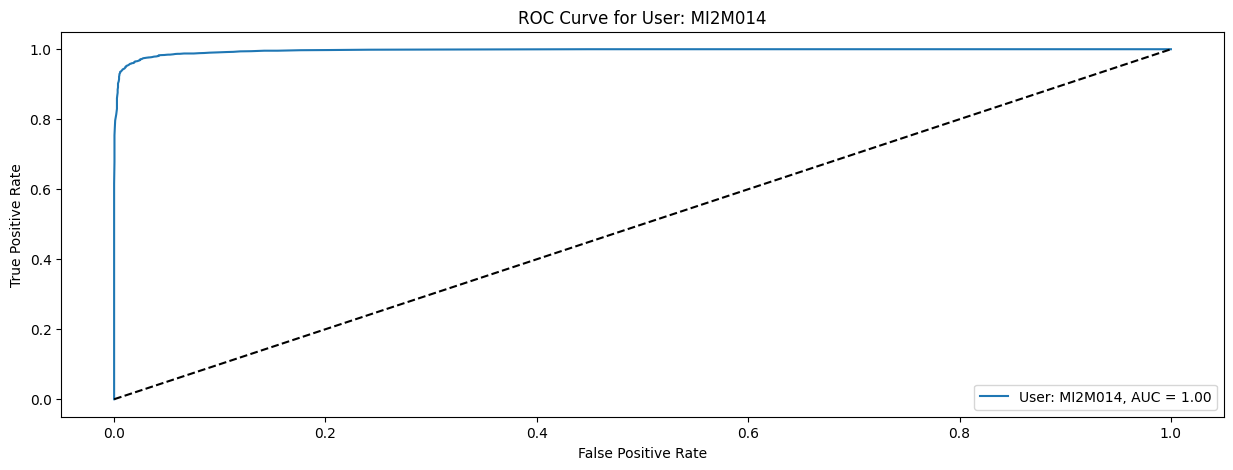

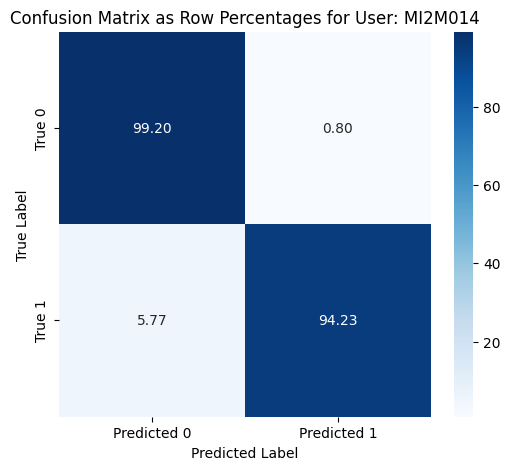

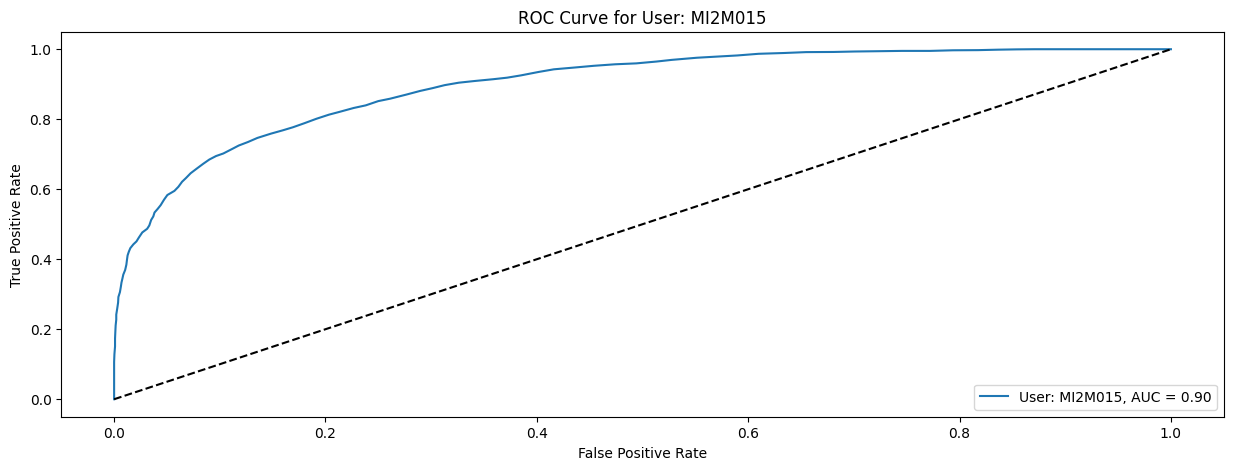

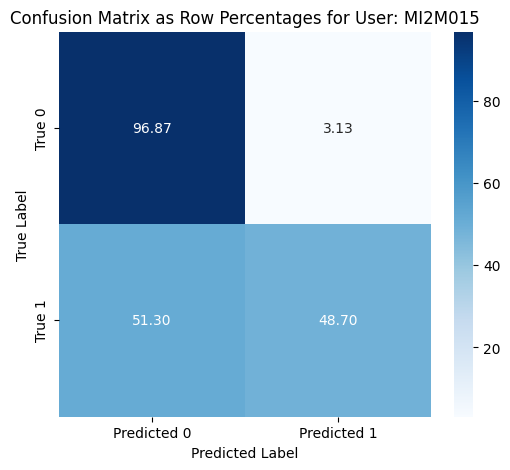

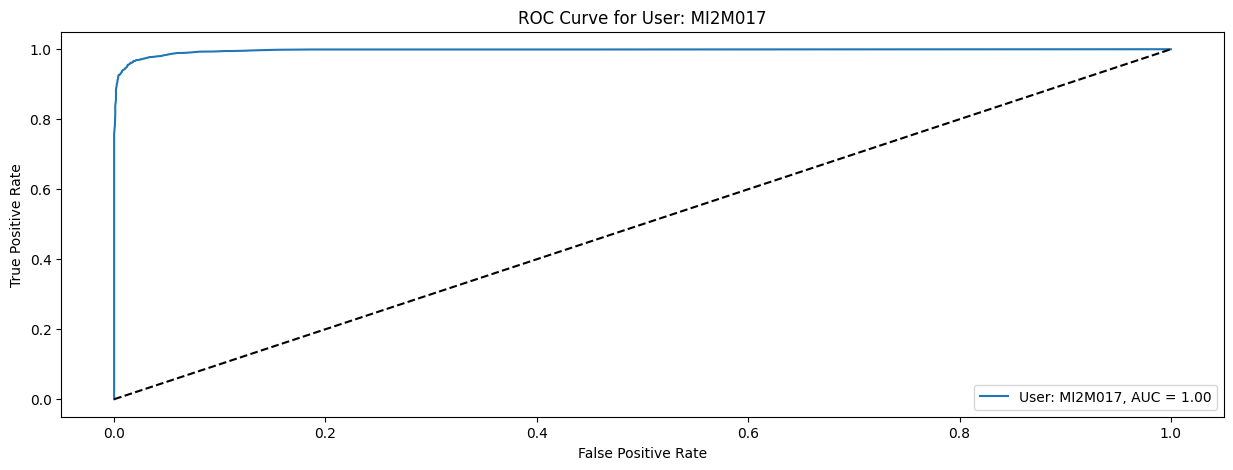

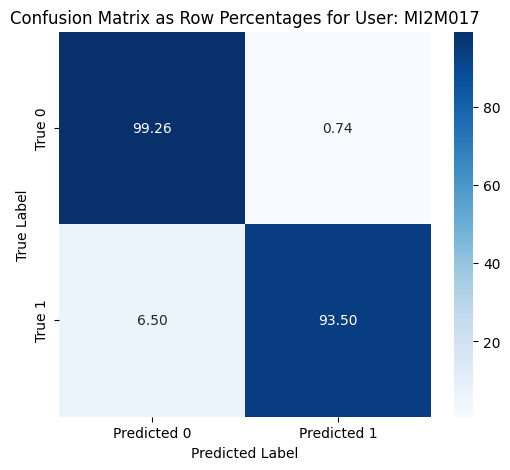

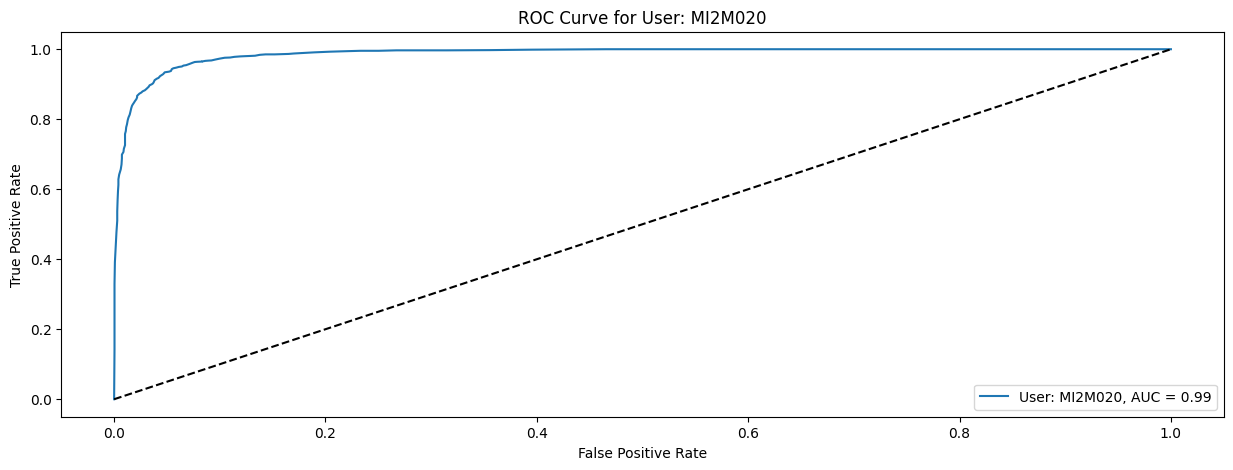

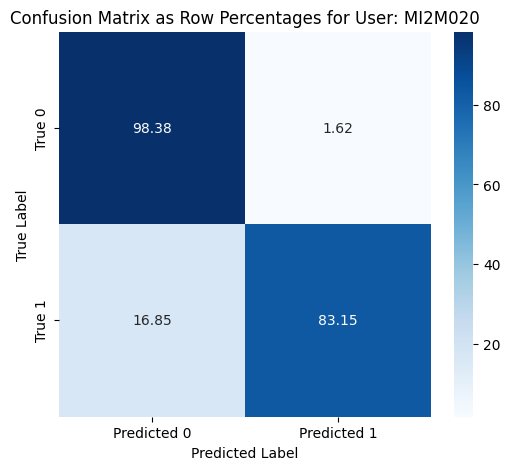

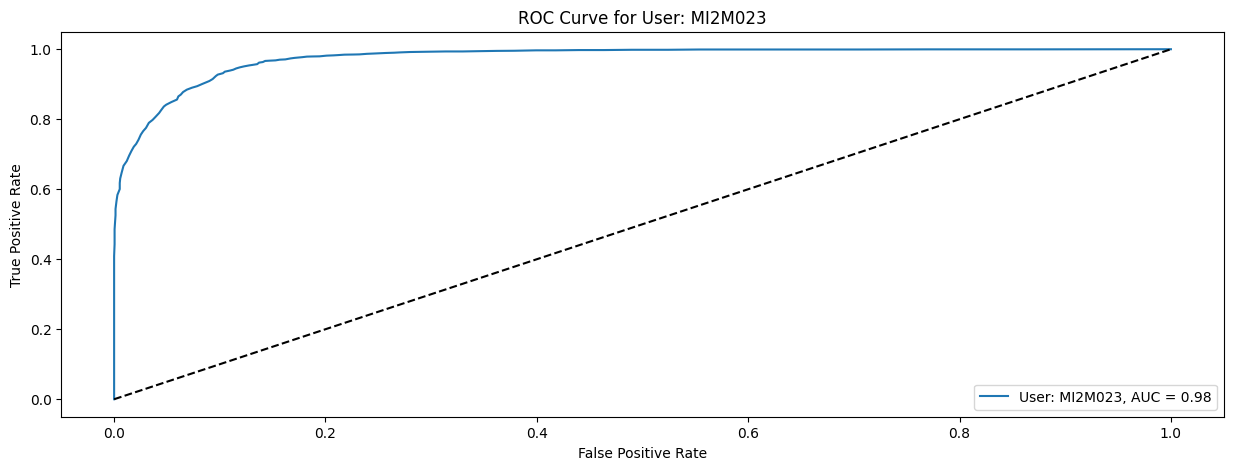

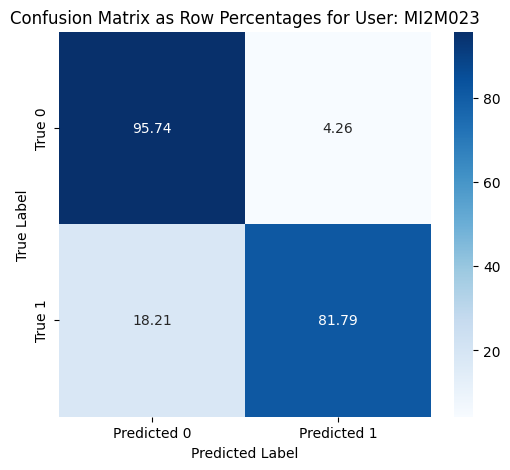

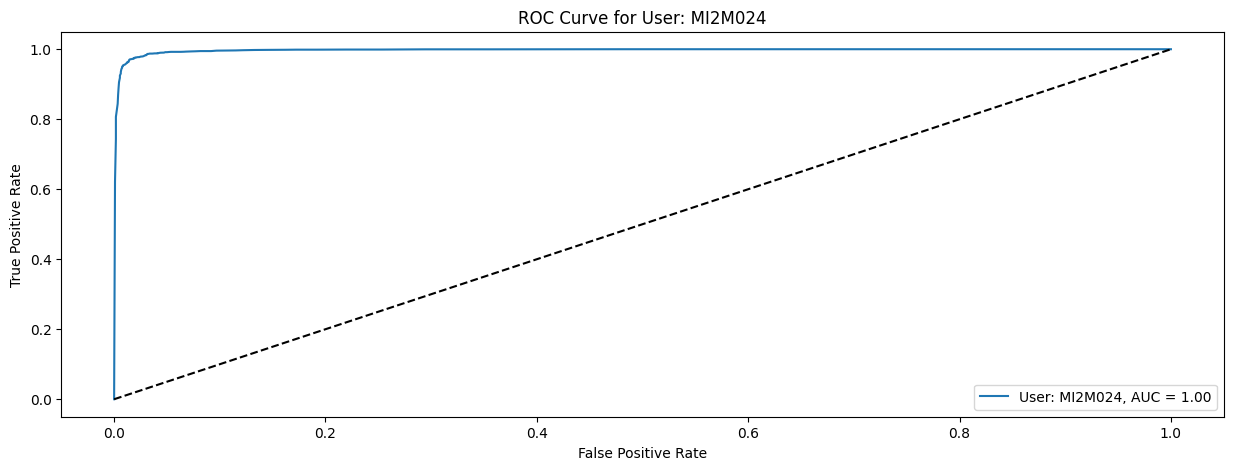

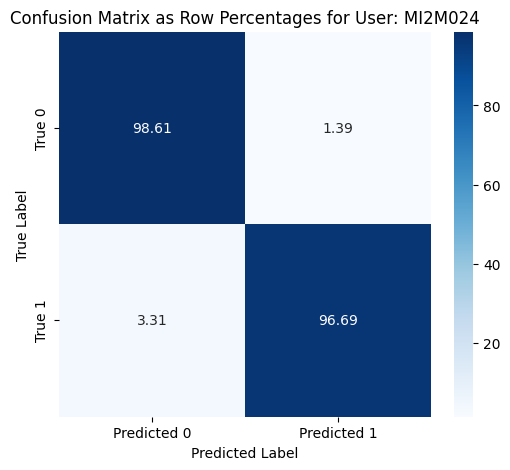

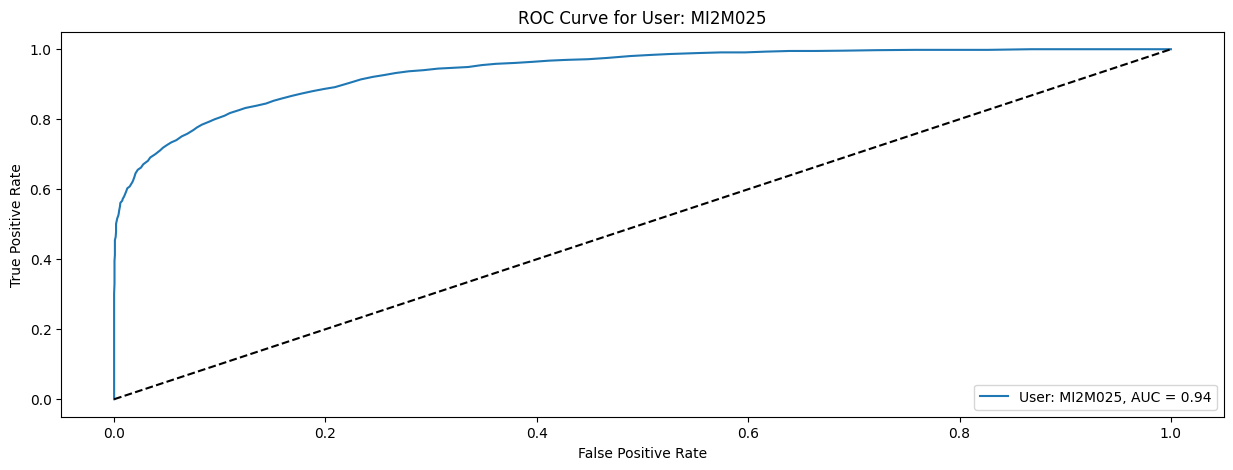

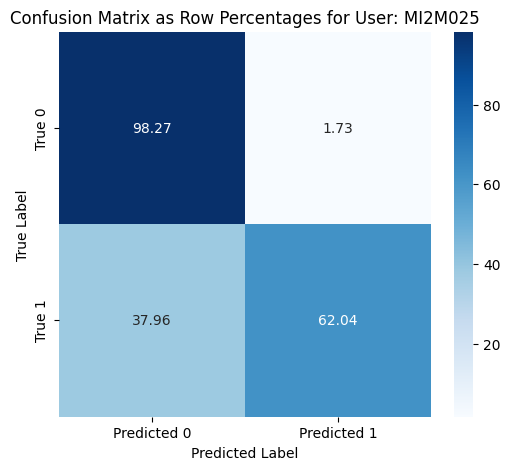

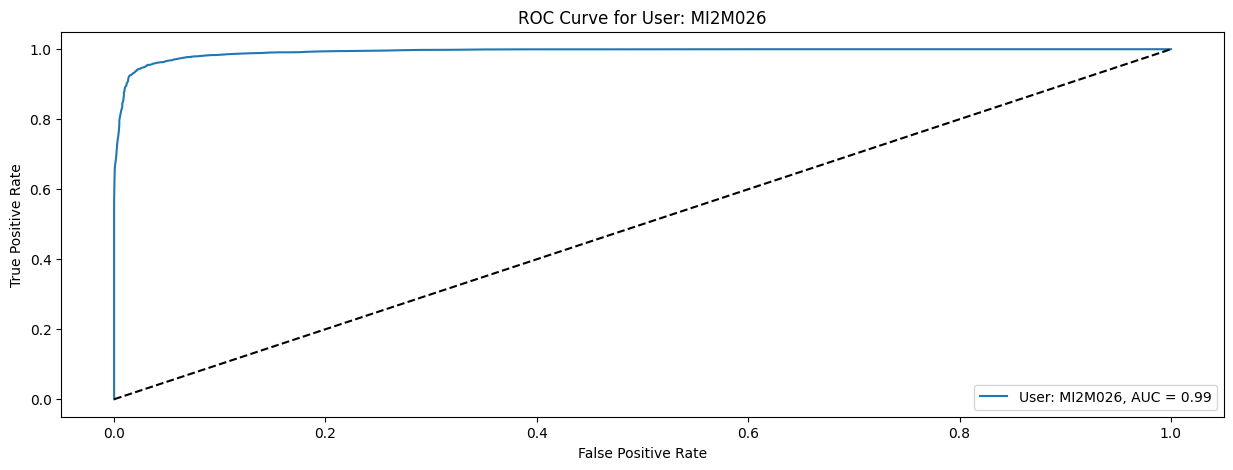

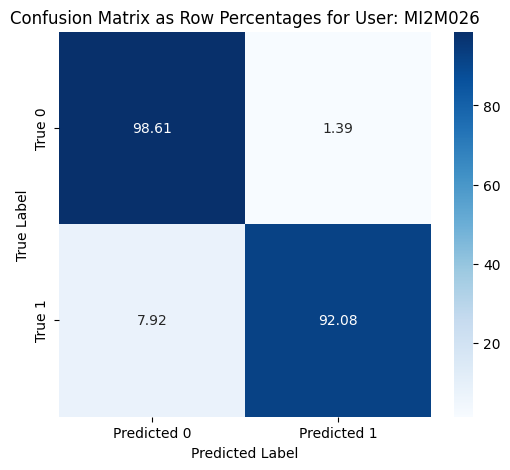

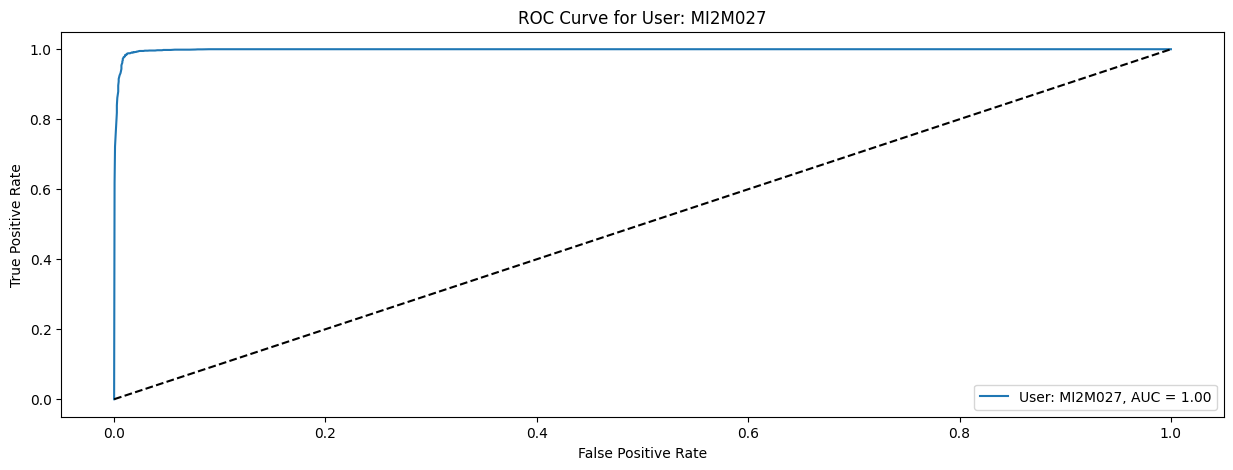

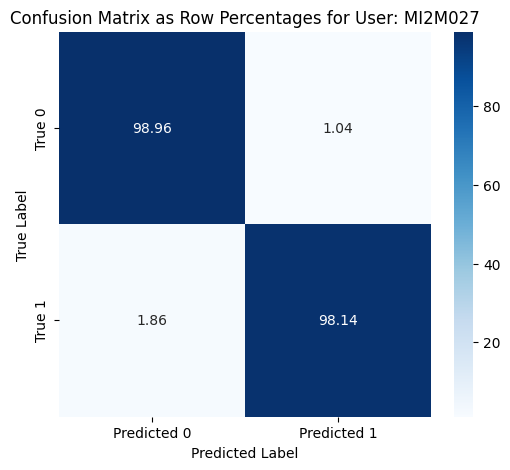

In [6]:
# Load the dataset
windowed_data = pd.read_csv('Empatica data.csv')

# Get unique users in the dataset
unique_users = windowed_data['user'].unique()

# Iterate over each unique user to analyze their data
for user in unique_users:
    # Filter data for the current user
    user_data = windowed_data[windowed_data['user'] == user].copy()

    # Drop columns that are not needed for modeling
    user_data = user_data.drop(['documentation_day', 'user'], axis=1)

    # Convert 'med' to binary if necessary:
    # In this dataset, 'med' values are 1 (regular dose) and 2 (high dose),
    # where 2 indicates that the regular dose was insufficient. We replace 1 with 0 (no high dose),
    # and 2 with 1 (high dose).
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Define features (X) and target (y)
    X = user_data.drop('med', axis=1)  # Features: all columns except 'med'
    y = user_data['med']  # Target: the 'med' column

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a Random Forest model on the training data
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve for the current user
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()

    # Generate and plot confusion matrix heatmaps for various thresholds
    for threshold in [0.7]:
        # Binarize predictions based on the current threshold
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        tn = ((y_pred == 0) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        # Calculate row-wise percentages for the confusion matrix
        true_0_total = tn + fp
        true_1_total = fn + tp
        conf_matrix_percent = [
            [tn / true_0_total * 100 if true_0_total > 0 else 0, fp / true_0_total * 100 if true_0_total > 0 else 0],
            [fn / true_1_total * 100 if true_1_total > 0 else 0, tp / true_1_total * 100 if true_1_total > 0 else 0]
        ]

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["True 0", "True 1"])
        plt.title(f'Confusion Matrix as Row Percentages for User: {user}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


# 2. Pre-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="2"></a>


In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load the users' daily data from CSV
users_daily = pd.read_csv('users_daily.csv')

# Drop unnecessary columns from the users' daily data
users_daily = users_daily.drop([
    'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean',
    'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr',
    'g_rms', 'rec_num_gyro', 'hrv_std', 'rec_num_hrv'
], axis=1)

# Rename the 'hrv_mean' column to 'hrv' for consistency
users_daily = users_daily.rename(columns={"hrv_mean": "hrv"})

# Load the trial data from CSV
trial_data = pd.read_csv('Empatica data.csv')

# Define the target column and columns to be excluded for modeling
target_column = 'med'
exclude_columns = ['documentation_day', 'user']

# Prepare the training data (X_train and y_train)
# X_train includes all columns except 'documentation_day', 'user', and 'med'
X_train = trial_data.drop(columns=exclude_columns + [target_column])
y_train = trial_data[target_column]

# Prepare the testing data (X_test) by excluding 'time_since_med', 'user', 'date', and 'day' columns
X_test = users_daily.drop(columns=['time_since_med', 'user', 'date', 'day'])

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model using the training data
rf.fit(X_train, y_train)

# Predict the probabilities for the test data
# We are interested in the probabilities for class 1 (positive outcome)
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Add the predicted probabilities as a new column in the users' daily data
users_daily['predicted_proba'] = y_pred_proba


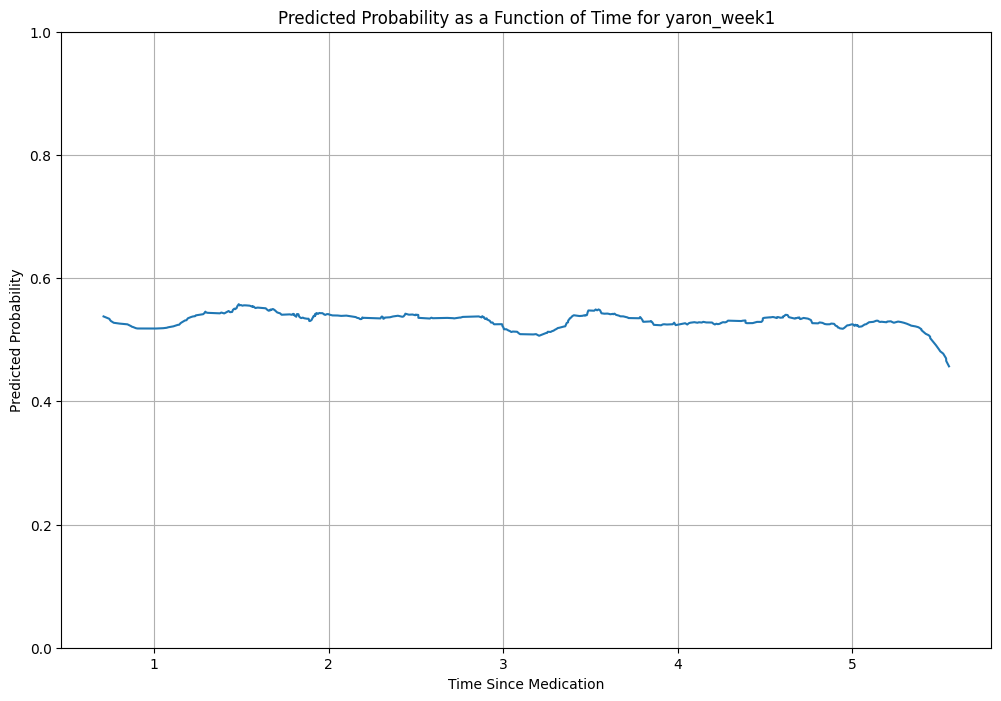

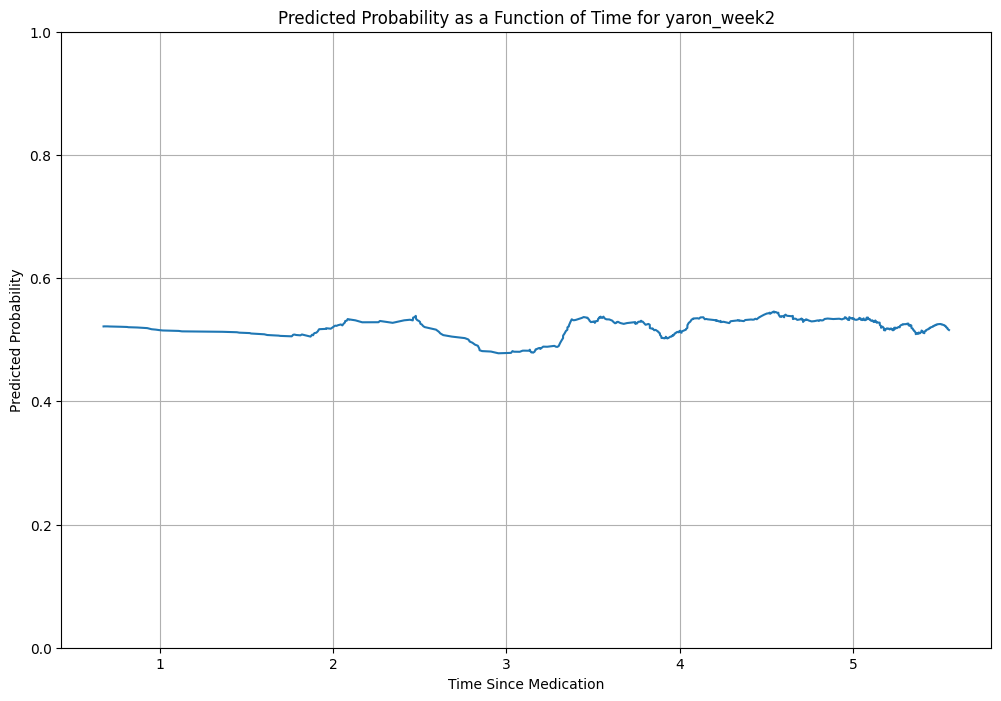

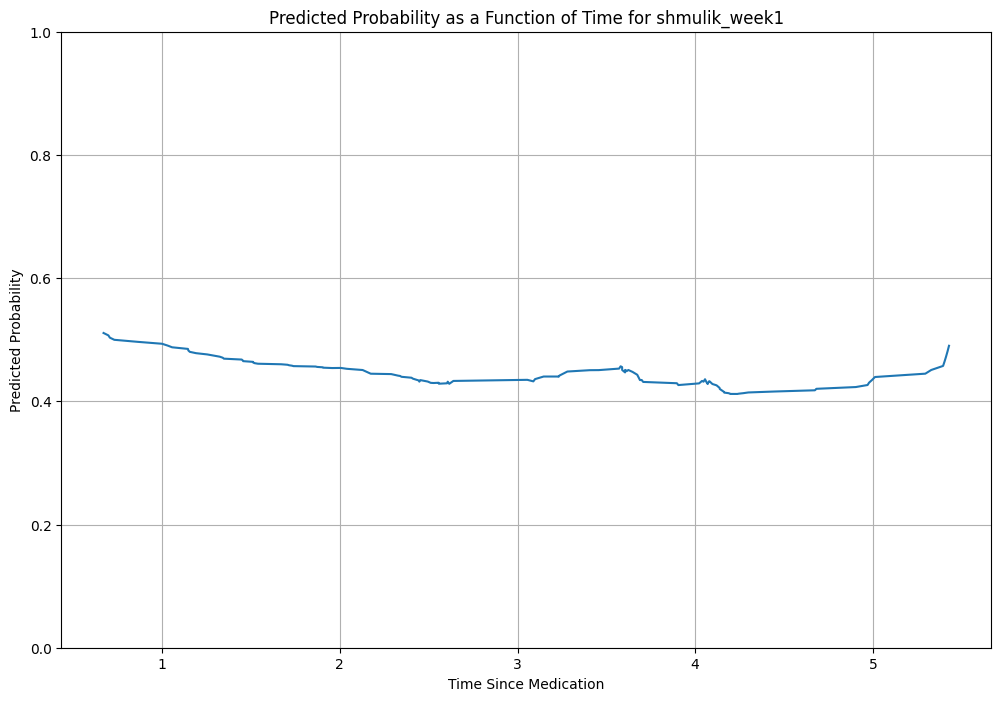

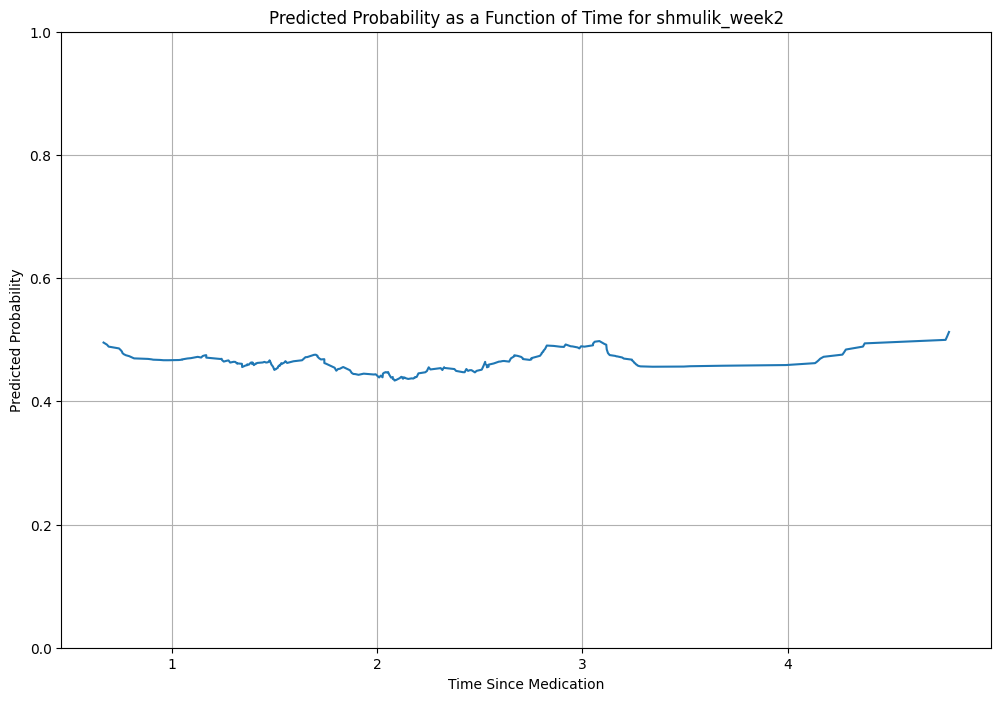

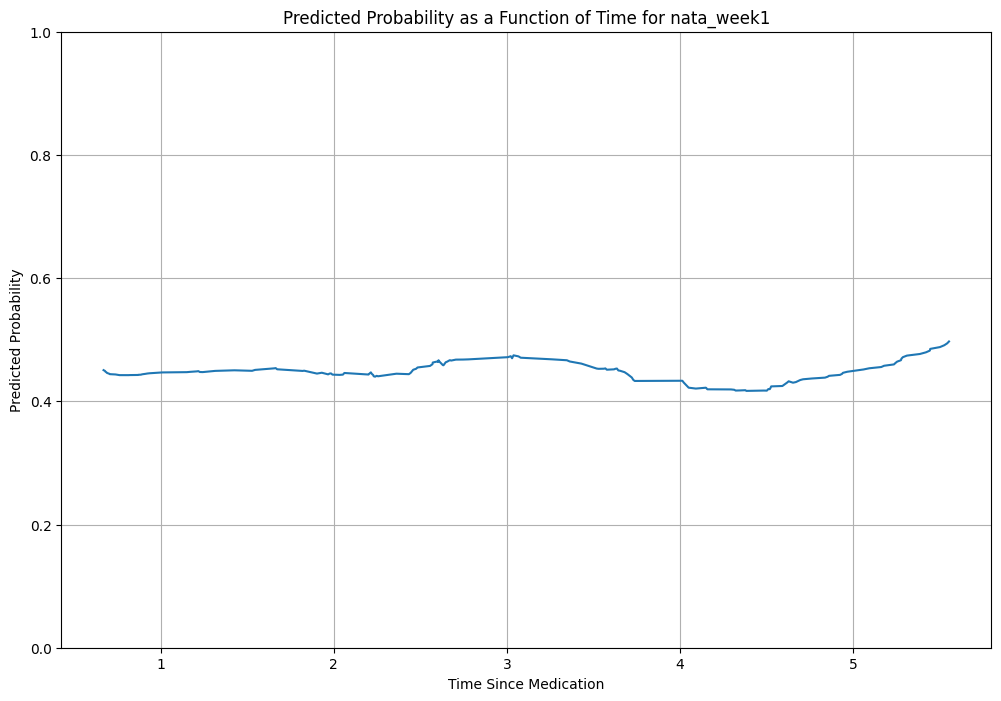

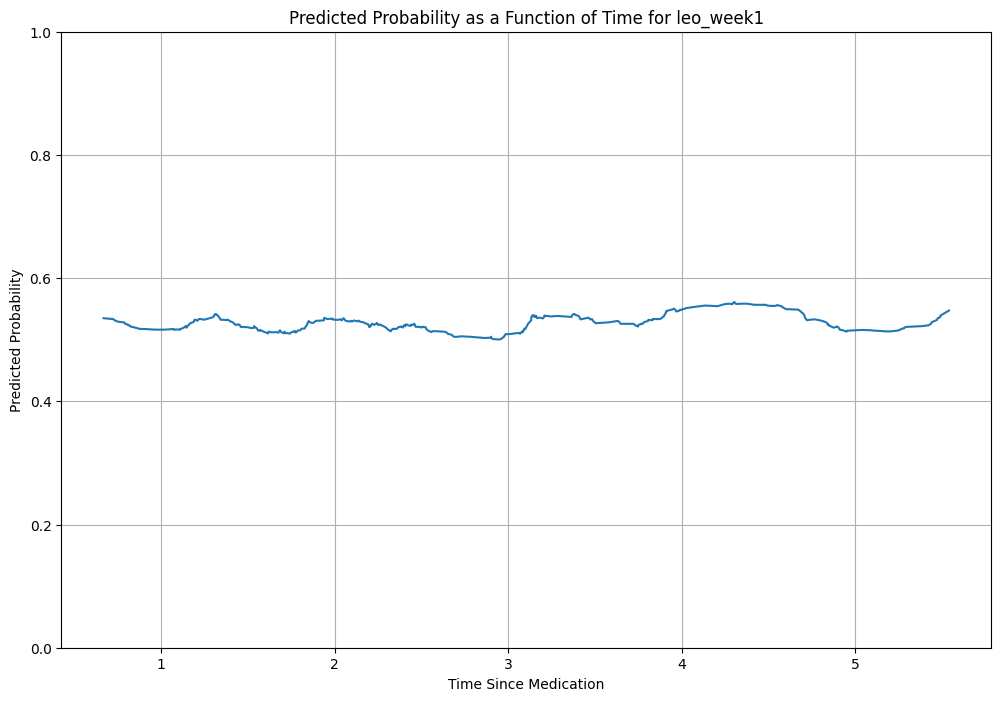

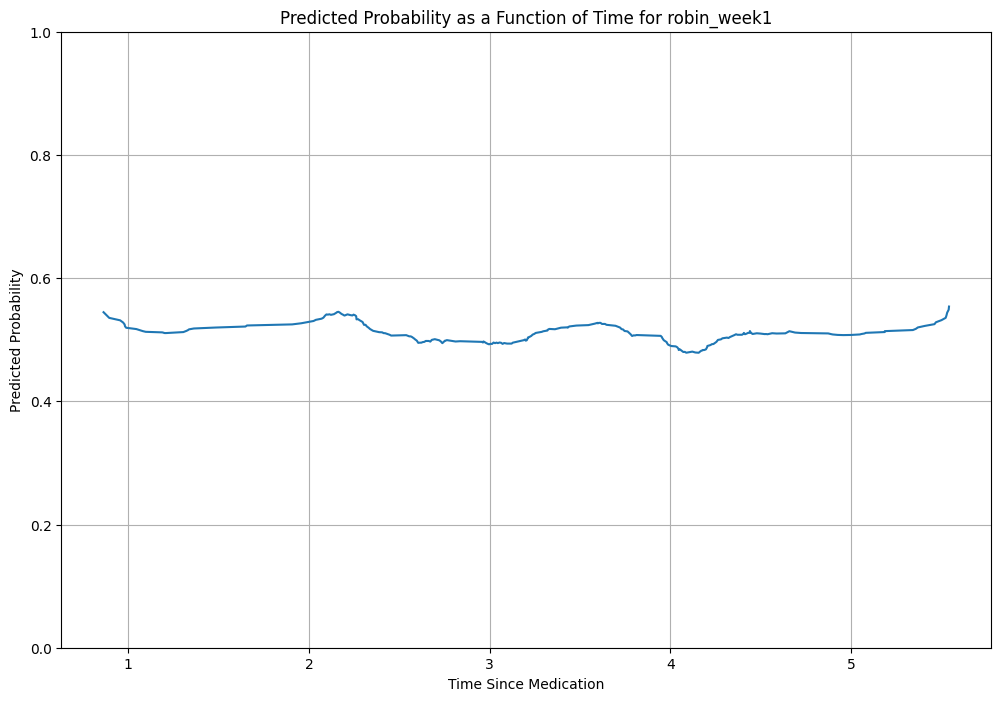

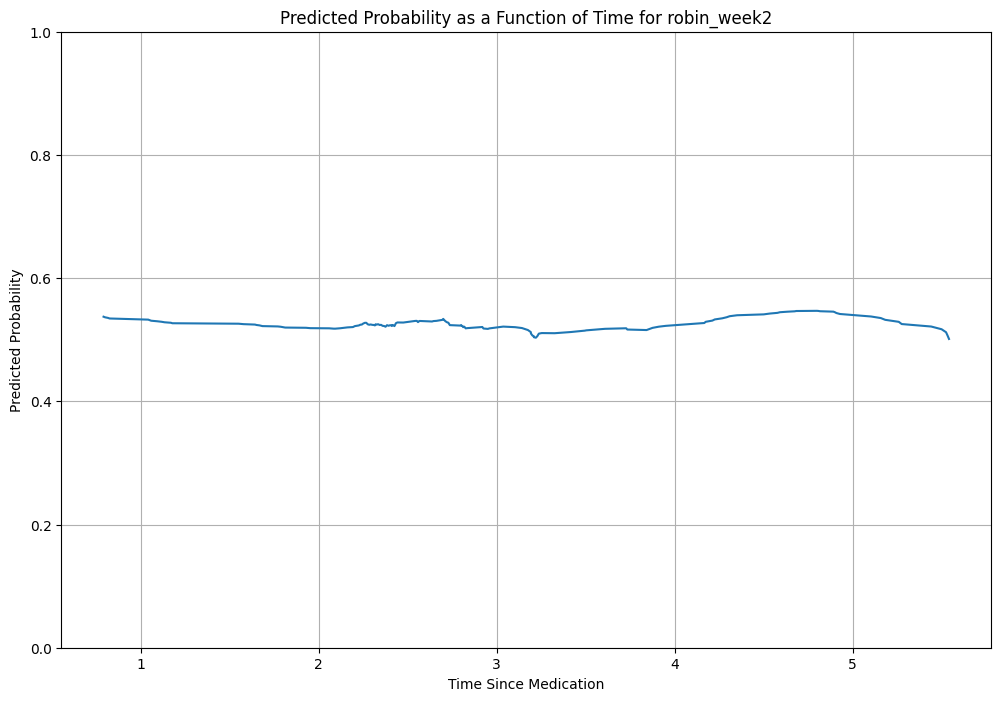

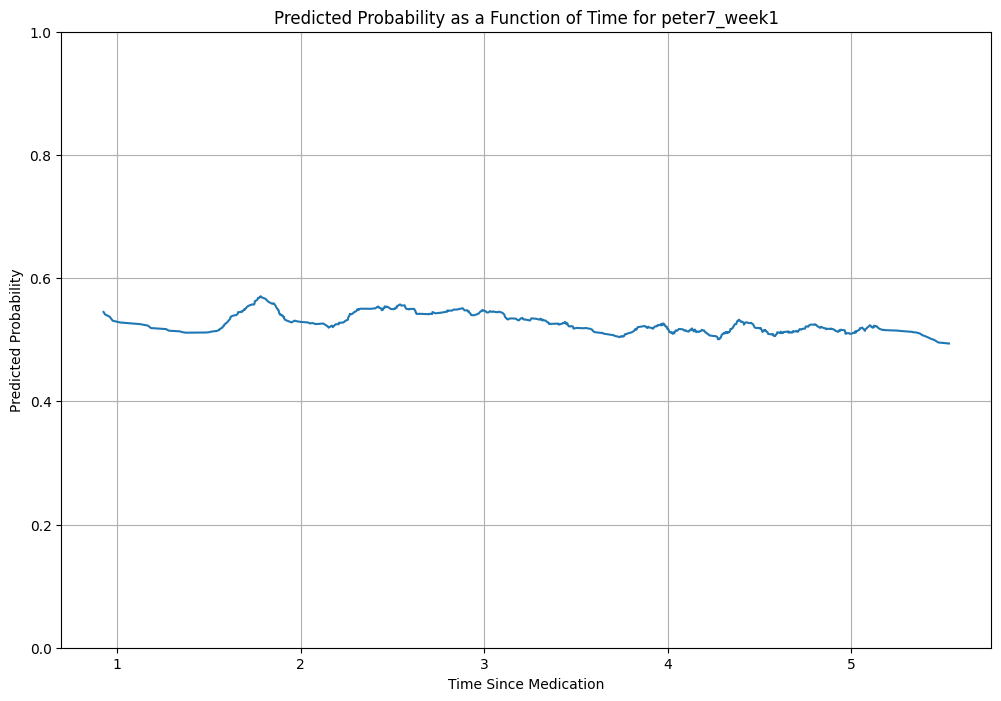

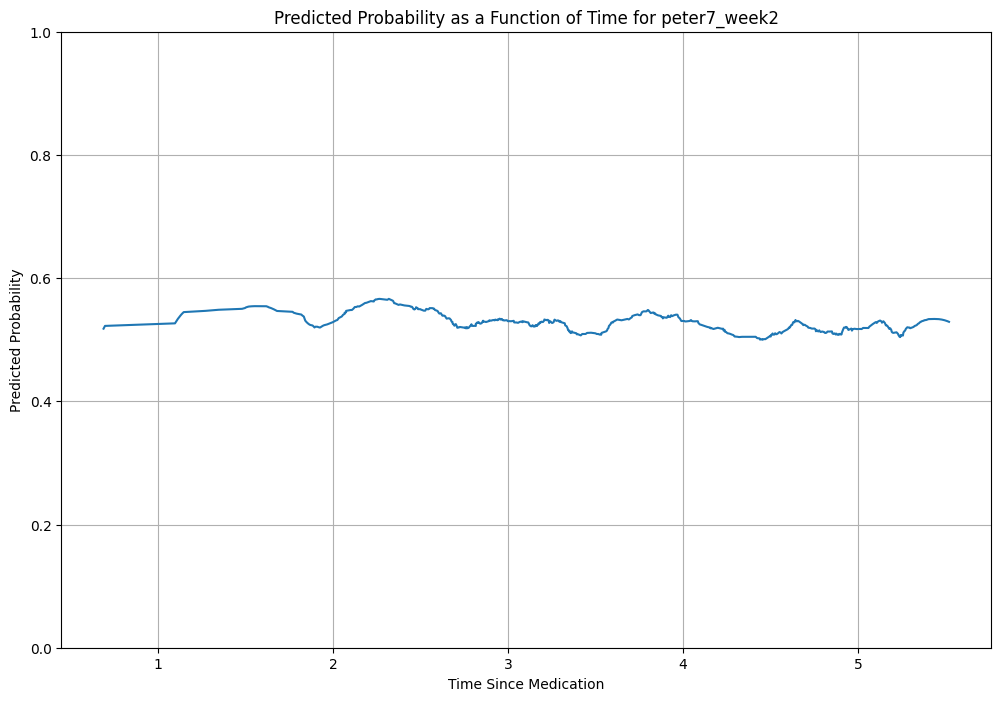

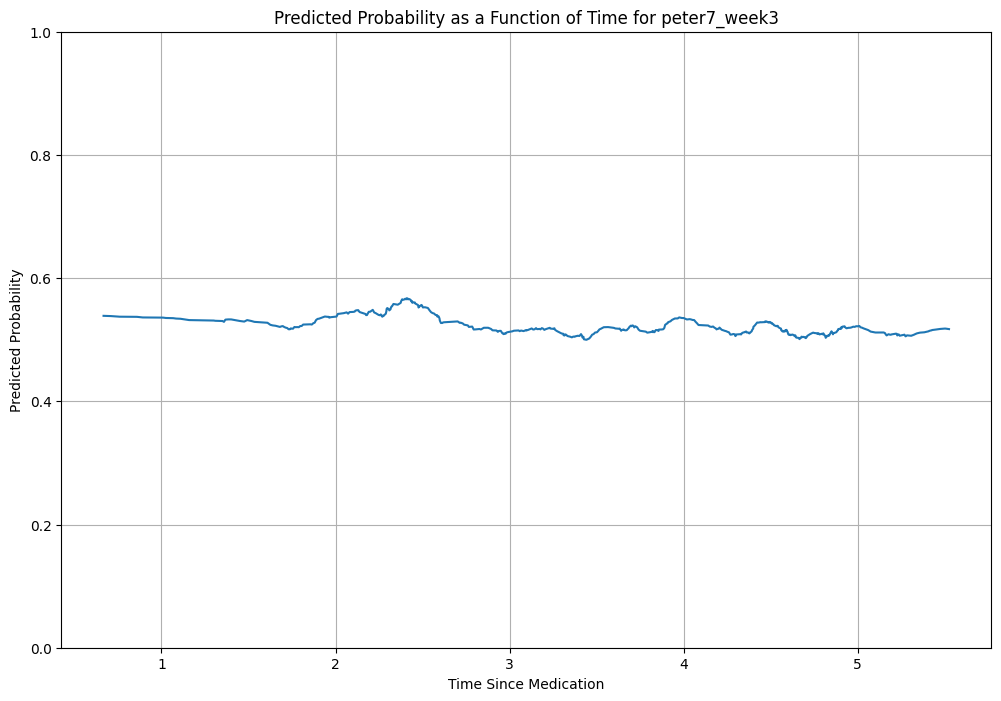

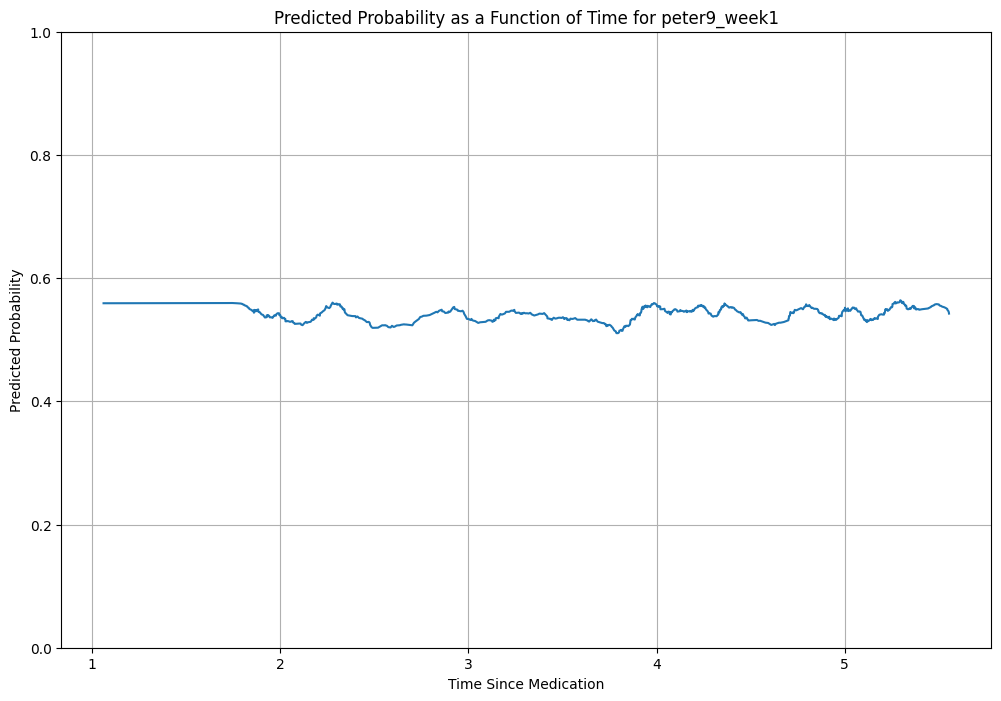

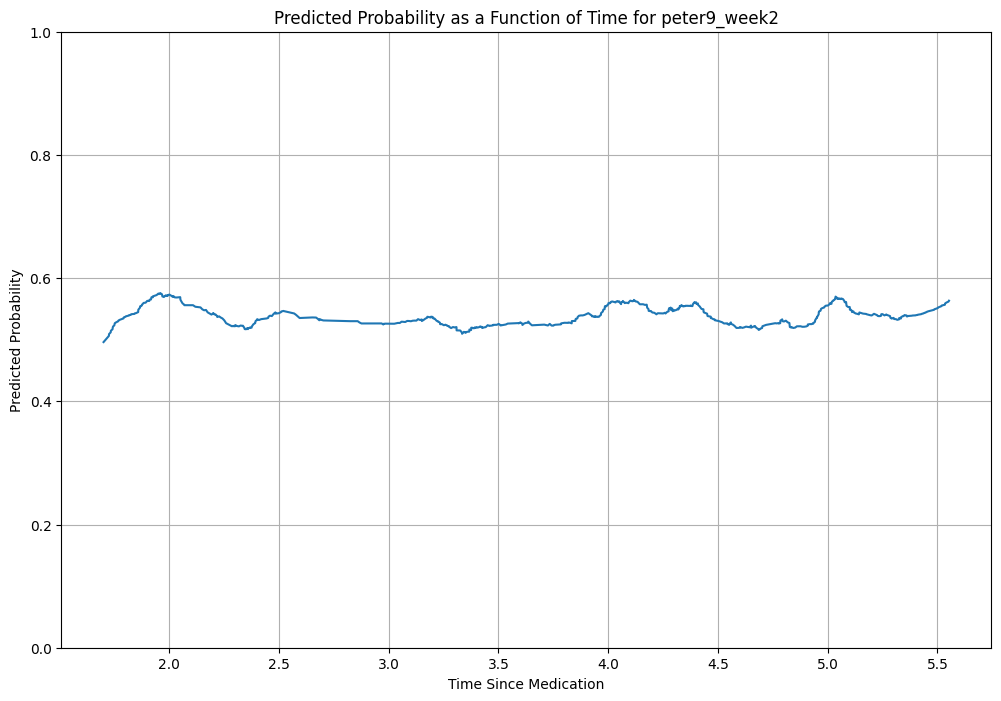

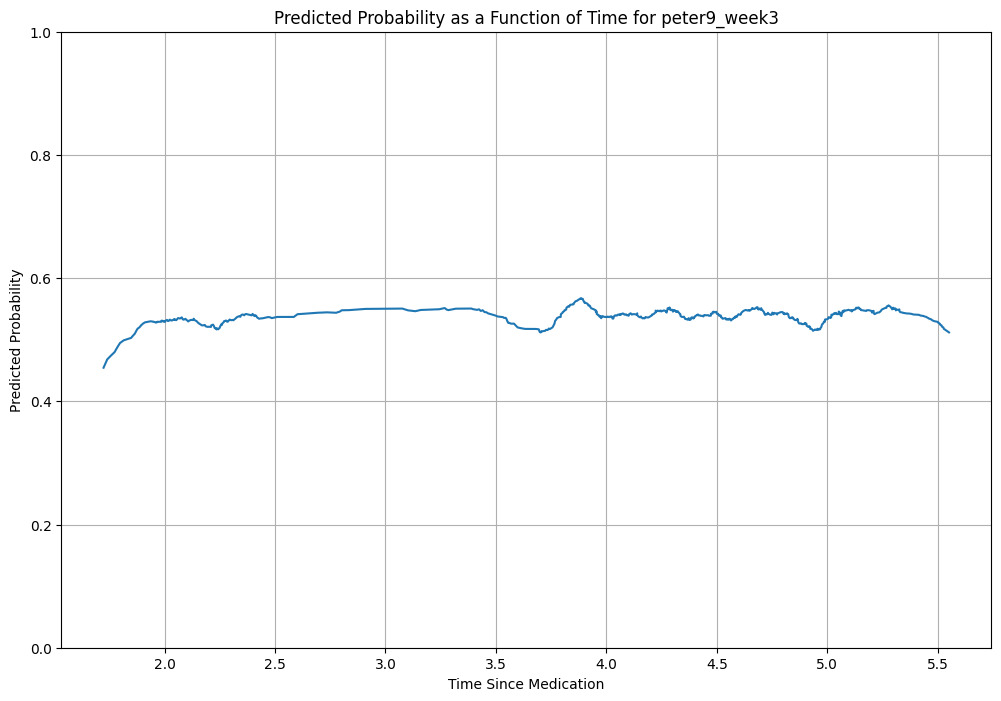

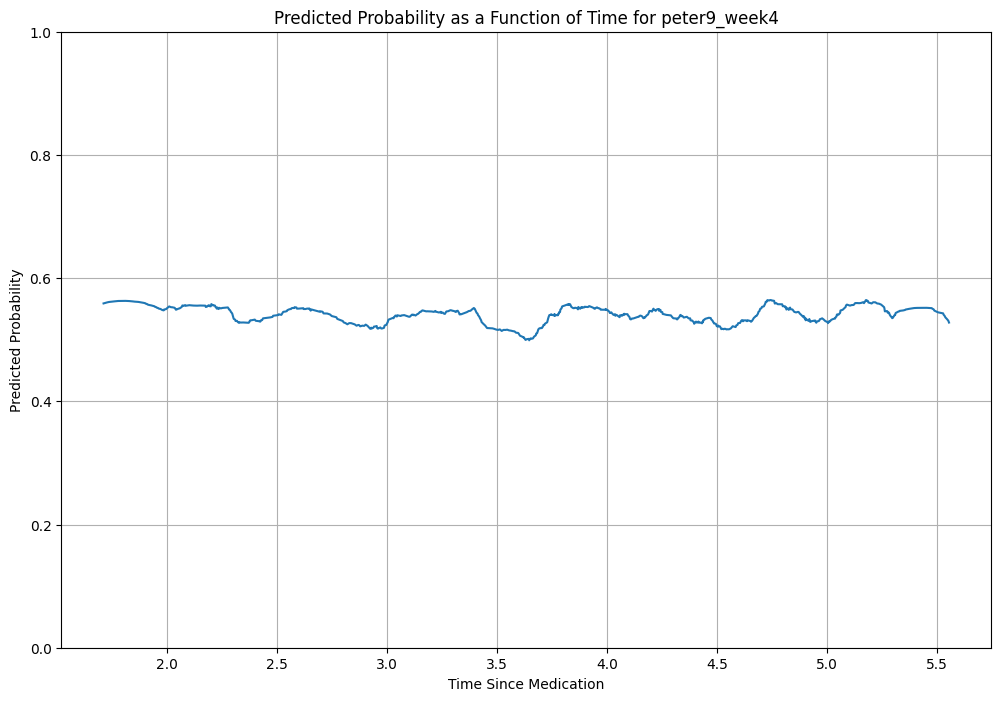

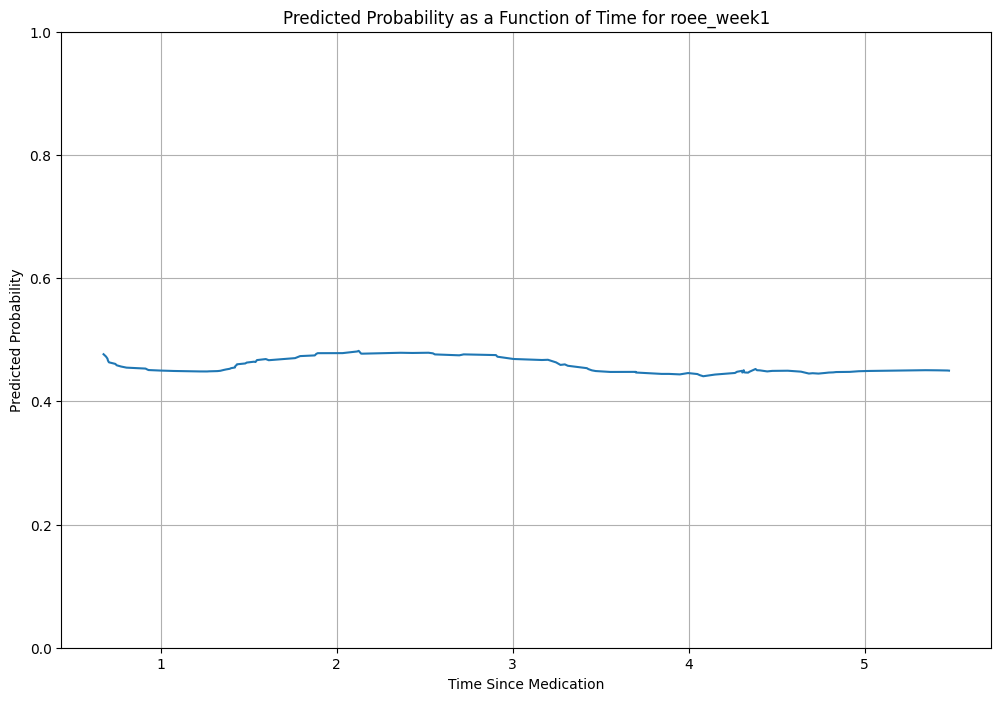

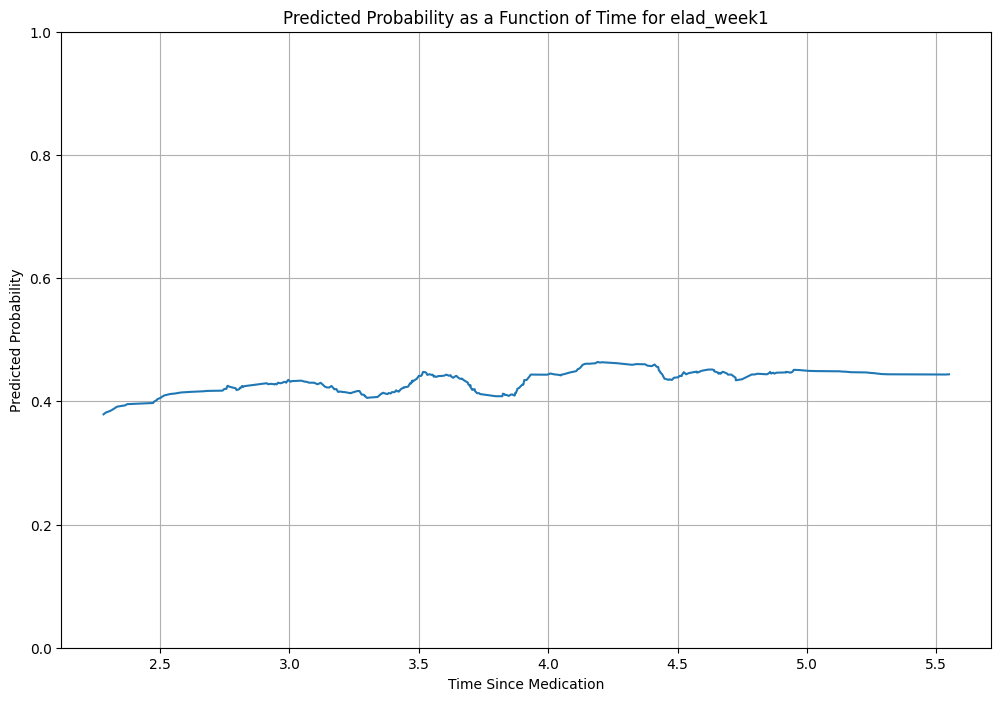

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Get the unique users from the 'users_daily' DataFrame
users = users_daily["user"].unique()

# Iterate over each user to generate a plot
for user in users:
    # Filter the DataFrame for the current user and sort by 'time_since_med'
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    
    # Extract the 'time_since_med' and 'predicted_proba' columns for plotting
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    
    # Create a new figure for the current user
    plt.figure(figsize=(12, 8))
    
    # Apply the Savitzky-Golay filter to smooth the predicted probability data
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    
    # Plot the smoothed predicted probability against time since medication
    plt.plot(x, y_savgol)
    
    # Set the labels and title for the plot
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.ylim(0, 1)  # Set y-axis limits to range between 0 and 1
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    
    # Add a grid to the plot for better readability
    plt.grid(True)
    
    # Display the plot
    plt.show()


# 3.GNN <a class="anchor" id="3"></a>


In [9]:
import pandas as pd
import torch

# Read the CSV file containing trial data
trial_data = pd.read_csv('Empatica data.csv')

# Create a unique identifier for each user by combining user ID, medication dosage, and documentation day
trial_data['user'] = trial_data['user'] + '_' + trial_data['med'].astype(str)
trial_data['user'] = trial_data['user'] + '_' + trial_data['documentation_day'].astype(str)

# Get the list of unique users based on the newly created 'user' column
unique_users = trial_data['user'].unique()

# Initialize lists to hold source and target nodes for the edge list
node1 = []
node2 = []
y = []

# Iterate through each unique user to construct edges
for user in unique_users:
    # Filter the trial data to include only rows for the current user
    windowed_data = trial_data[trial_data['user'] == user]
    
    # Get the index of the first and last rows for the current user
    first_index = windowed_data.index[0]
    last_index = windowed_data.index[-1]
    
    # Add the first and last indices to the node lists as starting and ending points
    node1.append(first_index)
    node2.append(first_index + 1)
    
    # Iterate over the range between the first and last indices to add edges between consecutive data points
    for i in range(first_index + 1, last_index):
        node1.append(i)         # Source node
        node2.append(i - 1)     # Target node (previous node)
        node1.append(i)         # Source node
        node2.append(i + 1)     # Target node (next node)
    
    # Add the last index and its preceding node to complete the edge list for the current user
    node1.append(last_index)
    node2.append(last_index - 1)
    
    # Print the current user's details for debugging/verification
    print(user)
    print(f"start: {first_index}")
    print(f"end: {last_index}")

# Create a PyTorch tensor for the edge list, which includes the source and target nodes
edge_list = torch.tensor([
                         node1,  # Source nodes
                         node2   # Target nodes
                        ], dtype=torch.long)


MI2M014_0_1
start: 0
end: 9913
MI2M014_1_2
start: 9914
end: 17072
MI2M015_0_1
start: 17073
end: 17265
MI2M015_0_2
start: 17266
end: 18558
MI2M015_0_3
start: 18559
end: 21256
MI2M015_0_4
start: 21257
end: 22291
MI2M015_0_5
start: 22292
end: 28374
MI2M015_0_6
start: 28375
end: 28567
MI2M015_1_7
start: 28568
end: 36247
MI2M017_0_1
start: 36248
end: 45740
MI2M017_1_2
start: 45741
end: 54728
MI2M020_0_1
start: 54729
end: 55560
MI2M020_0_2
start: 55561
end: 58031
MI2M020_0_3
start: 58032
end: 63745
MI2M020_1_4
start: 63746
end: 67115
MI2M020_1_5
start: 67116
end: 68975
MI2M023_0_1
start: 68976
end: 76461
MI2M023_1_2
start: 76462
end: 84851
MI2M024_0_1
start: 84852
end: 87701
MI2M024_0_2
start: 87702
end: 90064
MI2M024_0_3
start: 90065
end: 92781
MI2M024_1_4
start: 92782
end: 103444
MI2M025_0_1
start: 103445
end: 106074
MI2M025_0_2
start: 106075
end: 112602
MI2M025_1_3
start: 112603
end: 119857
MI2M026_0_1
start: 119858
end: 130548
MI2M026_1_2
start: 130549
end: 140855
MI2M027_0_1
start: 1408

In [10]:
y = trial_data["med"].values.tolist()

In [11]:
# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'hrv']

# Extract the values for the specified features
nodes = trial_data[features].values.tolist()
node_features = torch.tensor(nodes,dtype=torch.long)
node_y = torch.tensor(y,dtype=torch.long)



In [12]:
from torch_geometric.utils.convert import to_networkx

data = Data(x=node_features, edge_index=edge_list, y=node_y)


" Print the graph info "
print("Number of nodes: ", data.num_nodes)
print("Number of edges: ",data.num_edges)
print("Number of features per node (Length of feature vector): ", data.num_node_features,"\n")
print("Number of weights per edge (edge-features): ", data.num_edge_features, "\n")

" Plot the graph "

G = to_networkx(data)
#nx.draw_networkx(G)


Number of nodes:  156619
Number of edges:  313174
Number of features per node (Length of feature vector):  8 

Number of weights per edge (edge-features):  0 



In [13]:
#create train, test and validation masks
train_mask = torch.zeros(156619, dtype=torch.bool)
#train_mask[17073:103445] = True
train_mask[36248:] = True

test_mask = torch.zeros(156619, dtype=torch.bool)
test_mask[17073:36248] = True  #15

val_mask = torch.zeros(156619, dtype=torch.bool)
val_mask[0:17073] = True  #14


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Define a neural network class using the Graph Attention Network (GAT) architecture
class OurNet(torch.nn.Module):
    def __init__(self):
        """
        Initializes the OurNet class, which extends PyTorch's nn.Module.
        This class implements a GAT (Graph Attention Network) with three convolutional layers.
        """
        super(OurNet, self).__init__()
        
        # Number of hidden channels for the GAT layers
        hidden_channels = 8

        # First GAT layer: input with 'hidden_channels' features, output with 'hidden_channels' features,
        # 2 attention heads, and the outputs of the attention heads concatenated
        self.conv1 = GATConv(hidden_channels, hidden_channels, heads=2, concat=True)
        
        # Second GAT layer: input with 'hidden_channels * 2' features (due to concatenation of two attention heads),
        # output with 'hidden_channels' features, 2 attention heads, and the outputs concatenated
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        
        # Third GAT layer: input with 'hidden_channels * 2' features, output with 2 features,
        # 1 attention head, and output without concatenation
        self.conv3 = GATConv(hidden_channels * 2, 2, heads=1, concat=False)

        # Dropout layer for regularization with a dropout probability of 0.4
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        """
        Defines the forward pass of the network.
        
        Parameters:
        x (torch.Tensor): Node feature matrix with shape [num_nodes, num_features].
        edge_index (torch.Tensor): Graph connectivity in COO format with shape [2, num_edges].
        
        Returns:
        Tuple: A tuple containing:
            - embeddings (torch.Tensor): The node embeddings after the second GAT layer.
            - output (torch.Tensor): The output of the third GAT layer, processed with log_softmax for classification.
        """
        x = x.float()  # Ensure the input features are in float format
        
        # Apply the first GAT layer, followed by the ELU activation function and dropout
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        # Apply the second GAT layer, followed by the ELU activation function and dropout
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        
        # Store embeddings after the second GAT layer for potential use or analysis
        embeddings = x

        # Apply the third GAT layer to produce the final output
        x = self.conv3(x, edge_index)
        
        # Return the embeddings and the output with log_softmax applied for multi-class classification
        return embeddings, F.log_softmax(x, dim=1)

# Function to train the model
def train():
    """
    Trains the model for one epoch.
    """
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients of the optimizer
    # Compute the negative log-likelihood loss and backpropagate
    F.nll_loss(model(data.x, data.edge_index)[1][train_mask], data.y[train_mask]).backward()
    optimizer.step()  # Update the model parameters based on the gradients

# Function to evaluate the model
def test():
    """
    Evaluates the model's performance on the train, validation, and test masks.
    
    Returns:
    List: A list containing the accuracy for train, validation, and test sets.
    """
    model.eval()  # Set the model to evaluation mode
    logits = model(data.x, data.edge_index)[1]  # Get the output from the model
    accs = []  # List to store accuracies for each mask

    # Calculate the accuracy for each mask (train, validation, test)
    for mask in [train_mask, val_mask, test_mask]:
        pred = logits[mask].max(1)[1]  # Get the predicted class by taking the argmax of the logits
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()  # Calculate the accuracy
        accs.append(acc)  # Append the accuracy to the list

    return accs  # Return the list of accuracies


In [15]:
# Initialize variables for tracking performance and the number of tries
test_acc = 0  # Variable to store the best test accuracy
val_acc = 0  # Variable to store the current validation accuracy
try_num = 0  # Counter for the number of attempts to reach the desired validation accuracy

# Loop until the validation accuracy is at least 0.7
while val_acc < 0.7:
    try_num += 1  # Increment the number of attempts

    # Set the device to GPU if available, otherwise fallback to CPU
    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

    # Initialize the model and move it to the selected device
    model, data = OurNet().to(device), data.to(device)

    # Define the optimizer with Adam, a learning rate of 0.001, and a weight decay of 5e-4 for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Initialize variables for tracking the best validation accuracy and corresponding test accuracy
    best_val_acc = test_acc = 0

    # Loop through epochs for training and evaluation
    for epoch in range(1, 5):
        # Train the model for one epoch
        train()

        # Evaluate the model on validation and test data
        _, val_acc, tmp_test_acc = test()

        # Update the best validation accuracy and corresponding test accuracy if a new best is found
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc

        # Print progress for every epoch
        log = 'Epoch: {:03d}, Test: {:.4f}, Val: {:.4f}'
        if epoch % 1 == 0:
            print(log.format(epoch, test_acc, val_acc))

# Print the number of attempts made to achieve the desired validation accuracy
print(f"try number: {try_num}")


Epoch: 001, Test: 0.4005, Val: 0.4193
Epoch: 002, Test: 0.4005, Val: 0.4151
Epoch: 003, Test: 0.4005, Val: 0.4058
Epoch: 004, Test: 0.4005, Val: 0.3856
Epoch: 001, Test: 0.3824, Val: 0.4087
Epoch: 002, Test: 0.3847, Val: 0.4128
Epoch: 003, Test: 0.3864, Val: 0.4164
Epoch: 004, Test: 0.3863, Val: 0.4201
Epoch: 001, Test: 0.5337, Val: 0.7137
Epoch: 002, Test: 0.5252, Val: 0.7215
Epoch: 003, Test: 0.5194, Val: 0.7259
Epoch: 004, Test: 0.5194, Val: 0.7237
try number: 3


In [16]:
users_daily

,time_since_med,x_mean,y_mean,z_mean,x_std,y_std,z_std,rms,hrv,user,day,date,predicted_proba
0,1.072683,-1.498744,-9.448413,0.772515,0.830578,0.973898,3.342419,5.541225,111.894697,yaron_week1,1,2.05,0.53
1,1.097683,0.703077,-1.441178,9.462996,1.327463,1.782649,1.373751,5.541348,258.673451,yaron_week1,1,2.05,0.56
2,1.281017,4.575934,-2.133391,6.938239,1.776041,4.004590,1.959975,4.954112,101.867631,yaron_week1,1,2.05,0.49
3,1.289350,3.061260,2.914816,8.572027,0.530262,0.823875,0.556614,5.518065,103.328085,yaron_week1,1,2.05,0.64
4,1.297683,0.783691,1.888943,9.318151,0.945952,0.670448,0.803883,5.507880,105.621076,yaron_week1,1,2.05,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247,5.269743,-3.269225,-5.665593,7.675982,1.473115,2.074023,3.566134,5.822585,0.715439,elad_week1,5,30.90,0.40
7248,5.303077,4.080318,-6.497414,6.116287,0.048586,0.139220,0.147121,5.664932,0.732512,elad_week1,5,30.90,0.46
7249,5.419743,6.069656,-3.436832,6.646038,0.719978,0.491318,0.789779,5.562444,0.681217,elad_week1,5,30.90,0.56
7250,5.486410,5.760258,-4.566604,6.427857,0.057020,0.175552,0.093944,5.637724,0.964479,elad_week1,5,30.90,0.45


In [17]:
#create graph representation for observational data.
unique_users = users_daily['user'].unique()
node1 =[]
node2 = []
for user in unique_users:
    windowed_data_user = users_daily[users_daily['user'] == user]
    unique_dates = windowed_data_user["date"].unique()
    for date in unique_dates:
        windowed_data_user_date = windowed_data_user[windowed_data_user["date"] == date]
        first_index = windowed_data_user_date.index[0]
        last_index = windowed_data_user_date.index[-1]
        node1.append(first_index)
        node2.append(first_index+1)
        for i in range(first_index+1,last_index):
            node1.append(i)
            node2.append(i-1)
            node1.append(i)
            node2.append(i+1)
        node1.append(last_index)
        node2.append(last_index-1)
        print(user, date)
        print(last_index)

new_edge_list = torch.tensor([
                         node1, # Source Nodes
                         node2  # Target Nodes
                        ], dtype=torch.long)

# List of features you want to extract
features = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 
            'rms', 'hrv']

# Extract the values for the specified features
nodes = users_daily[features].values.tolist()
new_node_features = torch.tensor(nodes,dtype=torch.long)

new_data = Data(x=new_node_features, edge_index=new_edge_list)


yaron_week1 2.05
59
yaron_week1 3.05
160
yaron_week1 5.05
178
yaron_week1 11.05
413
yaron_week2 24.05
505
yaron_week2 26.05
691
yaron_week2 7.06
733
yaron_week2 8.06
900
shmulik_week1 16.01
936
shmulik_week1 17.01
959
shmulik_week1 18.01
983
shmulik_week1 19.01
999
shmulik_week1 22.01
1028
shmulik_week2 23.01
1057
shmulik_week2 24.01
1186
shmulik_week2 25.01
1197
shmulik_week2 29.01
1216
shmulik_week2 30.01
1283
nata_week1 1.11
1324
nata_week1 2.11
1358
nata_week1 4.11
1396
nata_week1 6.11
1428
nata_week1 8.11
1451
leo_week1 24.01
1514
leo_week1 26.01
1554
leo_week1 2.02
1693
leo_week1 9.02
1719
leo_week1 10.02
1780
leo_week1 11.02
1830
robin_week1 13.01
1874
robin_week1 15.01
1894
robin_week1 16.01
1903
robin_week1 18.01
1919
robin_week1 23.01
2091
robin_week2 30.01
2101
robin_week2 24.03
2167
robin_week2 26.03
2203
robin_week2 27.03
2222
robin_week2 29.03
2251
peter7_week1 2.09
2419
peter7_week1 3.09
2610
peter7_week1 4.09
2696
peter7_week1 5.09
2886
peter7_week2 6.09
3104
peter7_wee

In [18]:
# get the new embedding for daily data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(new_data.x, new_data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU
users_daily = pd.read_csv('users_daily.csv')
# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if users_daily.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {users_daily.shape[0]} rows, but the tensor has {tensor_np.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    users_daily[new_features] = tensor_np
    print("New features added successfully!")


New features added successfully!


In [19]:
# get the new embedding for trial data

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    embeddings, _ = model(data.x, data.edge_index)
tensor_np = embeddings.cpu().detach().numpy()  # Convert tensor to NumPy array if it's still on GPU

# Define the new feature names for the tensor columns
new_features = [f'x{i+1}' for i in range(tensor_np.shape[1])]

# Ensure the dataframe and tensor have the same number of rows
if trial_data.shape[0] != tensor_np.shape[0]:
    print(f"Error: DataFrame has {trial_data.shape[0]} rows, but the tensor has {trial_data.shape[0]} rows.")
else:
    # Add the tensor data as new columns to the dataframe
    trial_data[new_features] = tensor_np
    print("New features added successfully!")


trial_data['user'] = trial_data['user'].str[:-4]


New features added successfully!


# 4. Post-GNN Evaluation of Trial Data <a class="anchor" id="4"></a>


### 4.2. ROC CURVE <a class="anchor" id="4.2"></a>


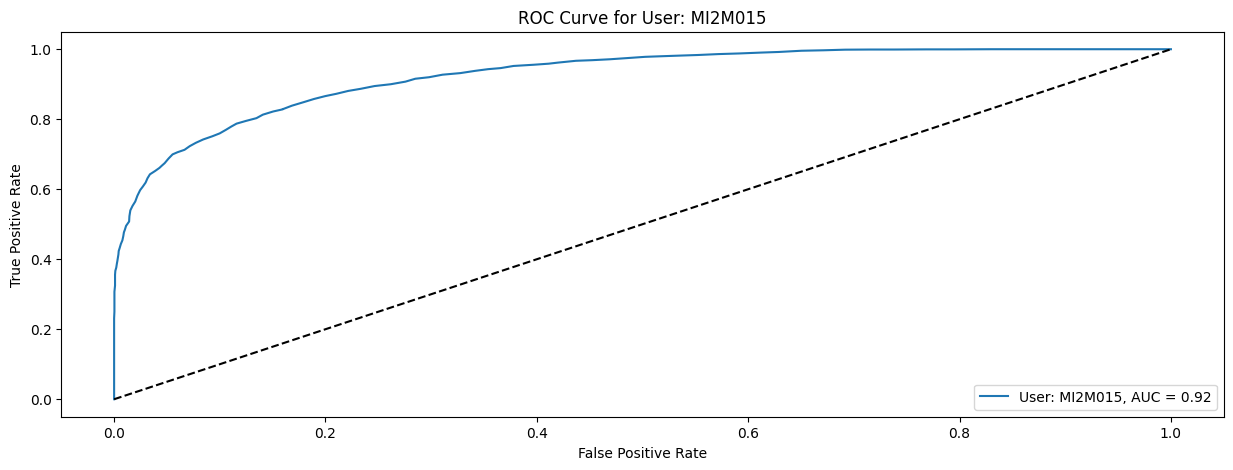

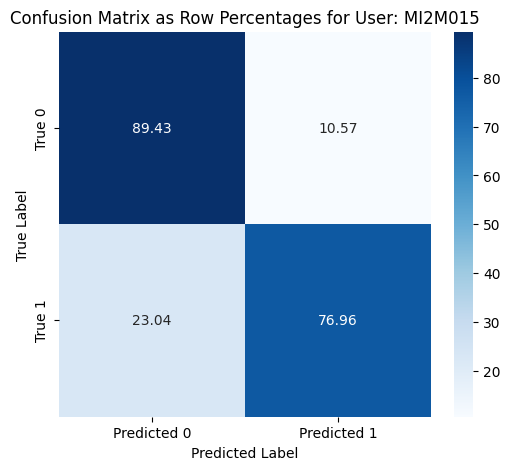

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of users to test the model on
test = ["MI2M015"]

# Get unique users from the trial dataset
unique_users = trial_data['user'].unique()

# Iterate over each specified user for analysis
for user in test:
    # Filter data for the current user and drop unnecessary columns
    user_data = trial_data[trial_data['user'] == user].copy()
    user_data = user_data.drop(columns=['documentation_day', 'user', 'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 
                                        'z_std', 'rms', 'hrv'])

    # Convert 'med' column to binary if it has 3 unique values (e.g., 1, 2, and a third value)
    if user_data['med'].nunique() == 3:
        user_data['med'] = user_data['med'].replace({1: 0, 2: 1})

    # Split the data into features (X) and target (y)
    X = user_data.drop('med', axis=1)
    y = user_data['med']

    # Split data into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train a Random Forest Classifier
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict probabilities for the test set (use probabilities for the positive class)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve (false positive rate, true positive rate, and thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate the AUC (Area Under the Curve) score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'User: {user}, AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line as a reference (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for User: {user}')
    plt.legend(loc='lower right')
    plt.show()

    for threshold in [0.5]:
        # Binarize predictions based on the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
        tp = ((y_pred == 1) & (y_test == 1)).sum()
        fp = ((y_pred == 1) & (y_test == 0)).sum()
        tn = ((y_pred == 0) & (y_test == 0)).sum()
        fn = ((y_pred == 0) & (y_test == 1)).sum()
        
        # Calculate the row-wise percentages for the confusion matrix
        true_0_total = tn + fp
        true_1_total = fn + tp
        conf_matrix_percent = [
            [tn / true_0_total * 100 if true_0_total > 0 else 0, fp / true_0_total * 100 if true_0_total > 0 else 0],
            [fn / true_1_total * 100 if true_1_total > 0 else 0, tp / true_1_total * 100 if true_1_total > 0 else 0]
        ]

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["True 0", "True 1"])
        plt.title(f'Confusion Matrix as Row Percentages for User: {user}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


# 5. Post-GNN Consolidated Weekly Graphs of Observational Data <a class="anchor" id="5"></a>


In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

target_column = 'med'  
exclude_columns = ['time_since_med', 'user']  


X_train = trial_data.drop(columns=['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'rms', 'hrv',
       'user', 'med', 'documentation_day']  )
y_train = trial_data[target_column]

X_test = users_daily.drop(columns=['time_since_med', 'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std',
       'z_std', 'rms', 'rec_num_acc', 'gx_mean', 'gy_mean', 'gz_mean',
       'gx_std', 'gy_std', 'gz_std', 'gx_zcr', 'gy_zcr', 'gz_zcr', 'g_rms',
       'rec_num_gyro', 'hrv_mean', 'hrv_std', 'rec_num_hrv', 'user', 'day',
       'date'])
#y_test = df2[target_column]

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model on df1
rf.fit(X_train, y_train)

# Predict probabilities on df2
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # get probability of class 1
users_daily['predicted_proba'] = y_pred_proba



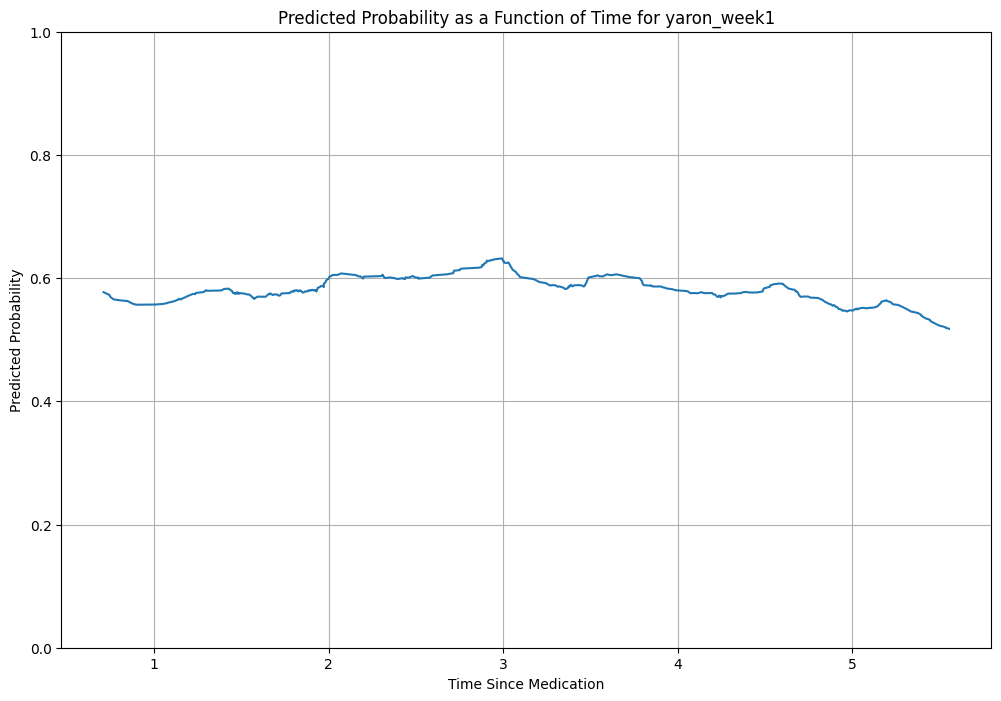

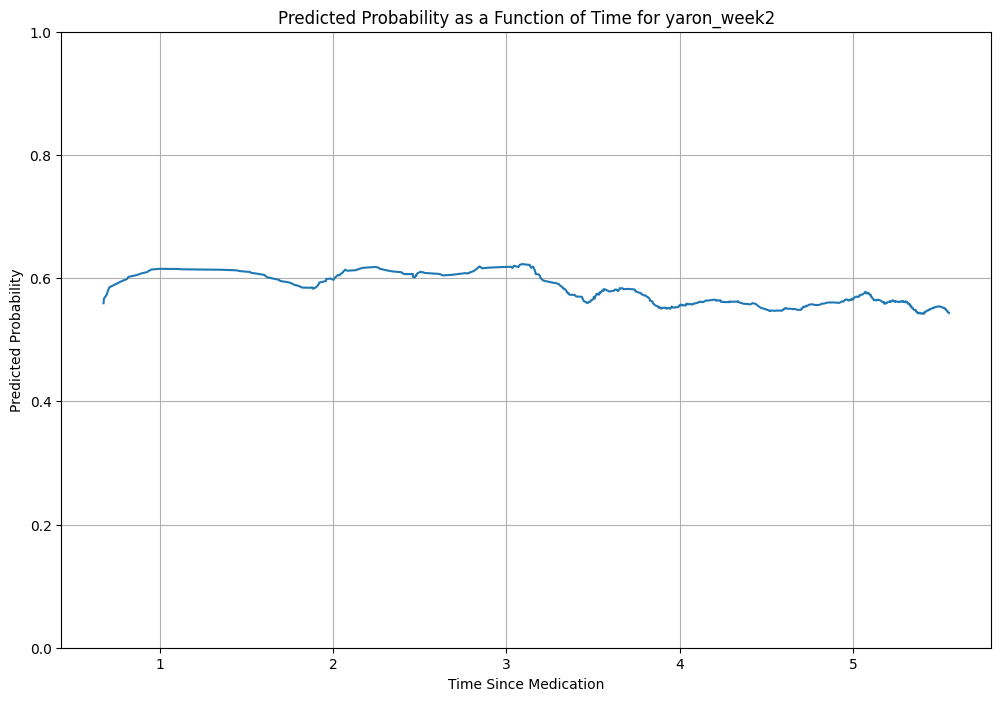

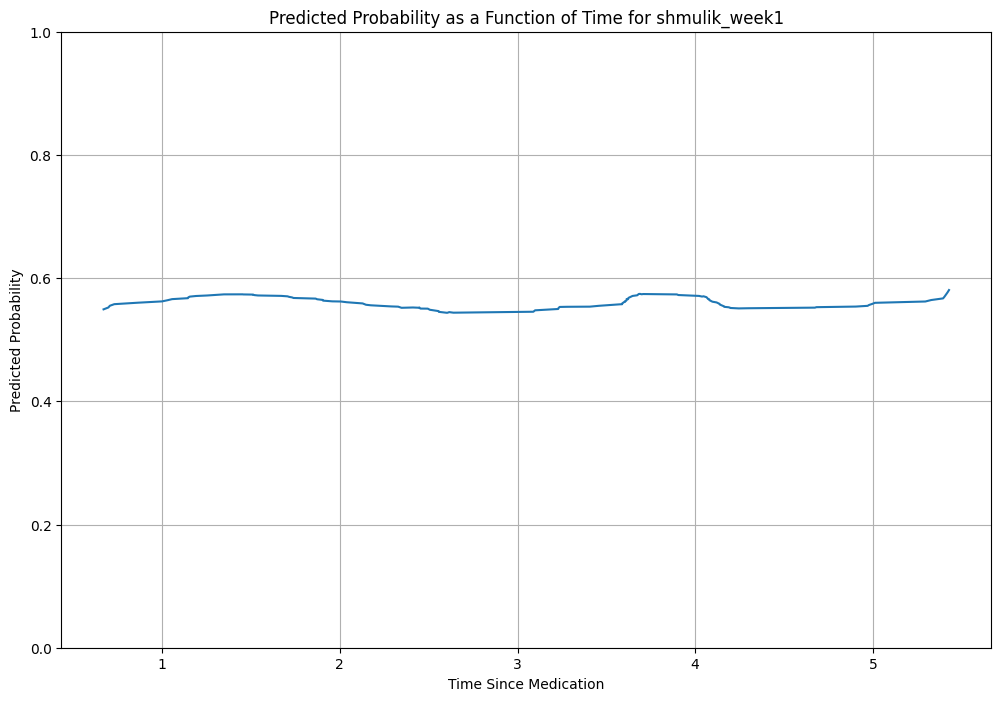

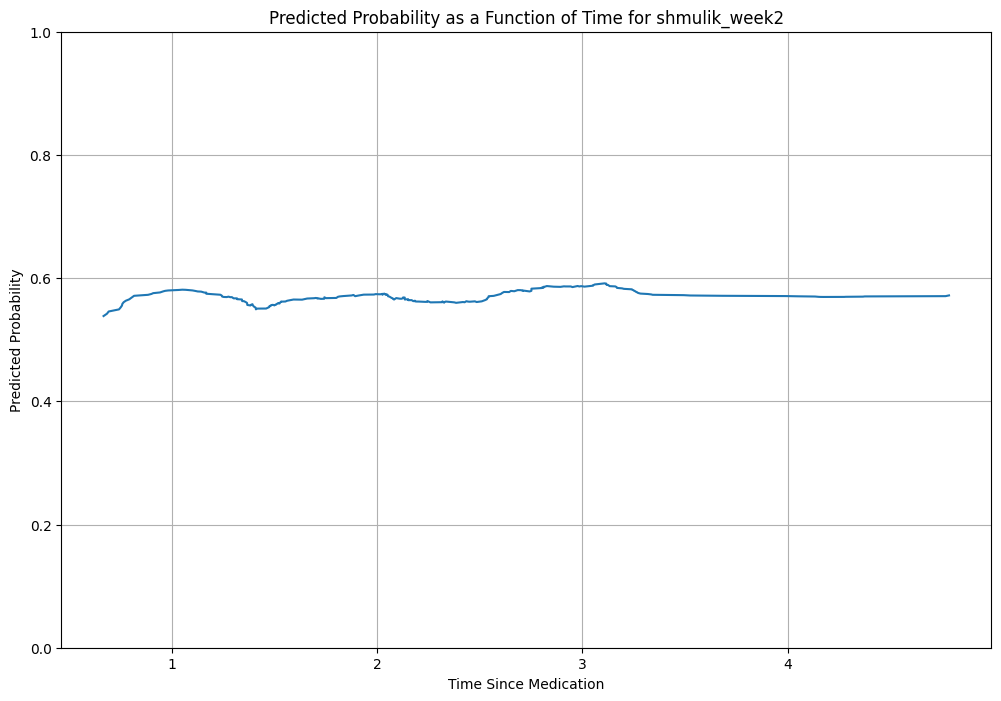

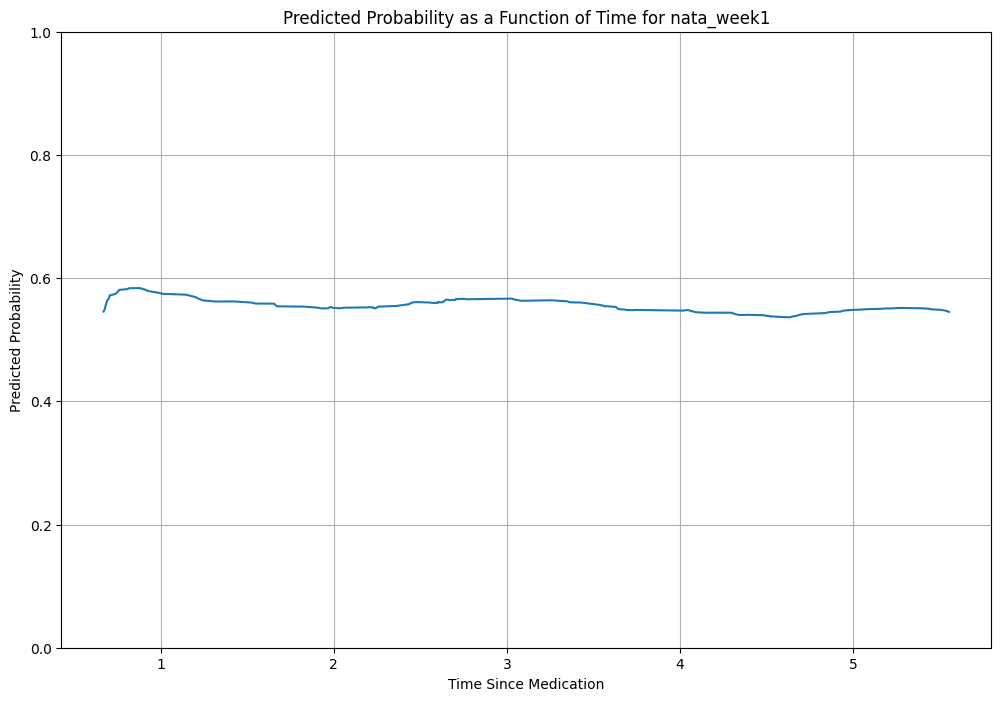

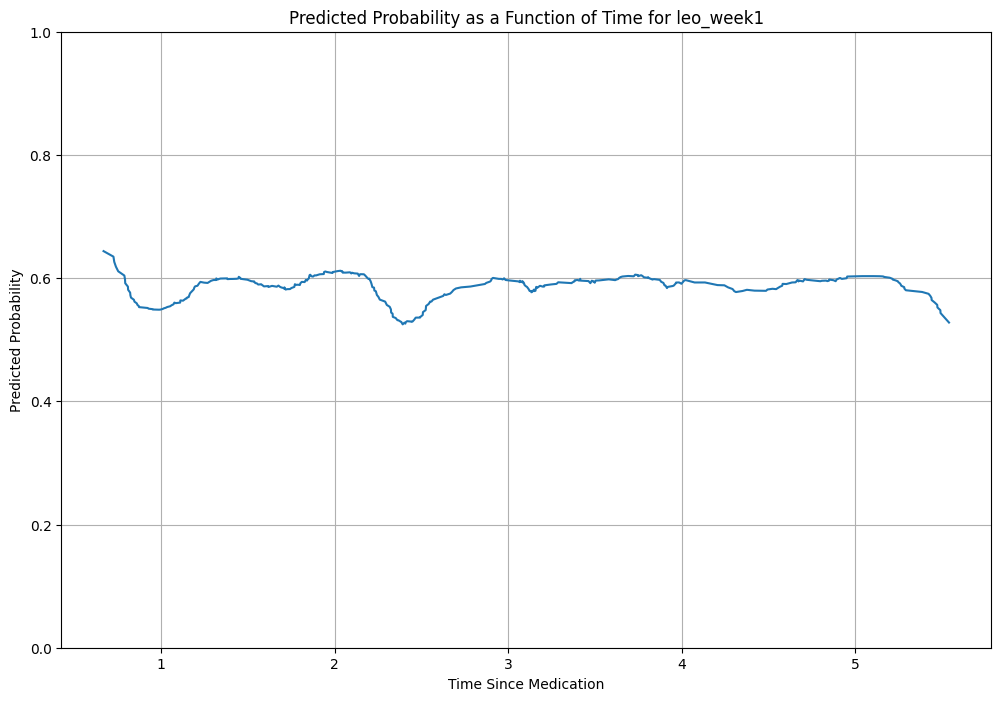

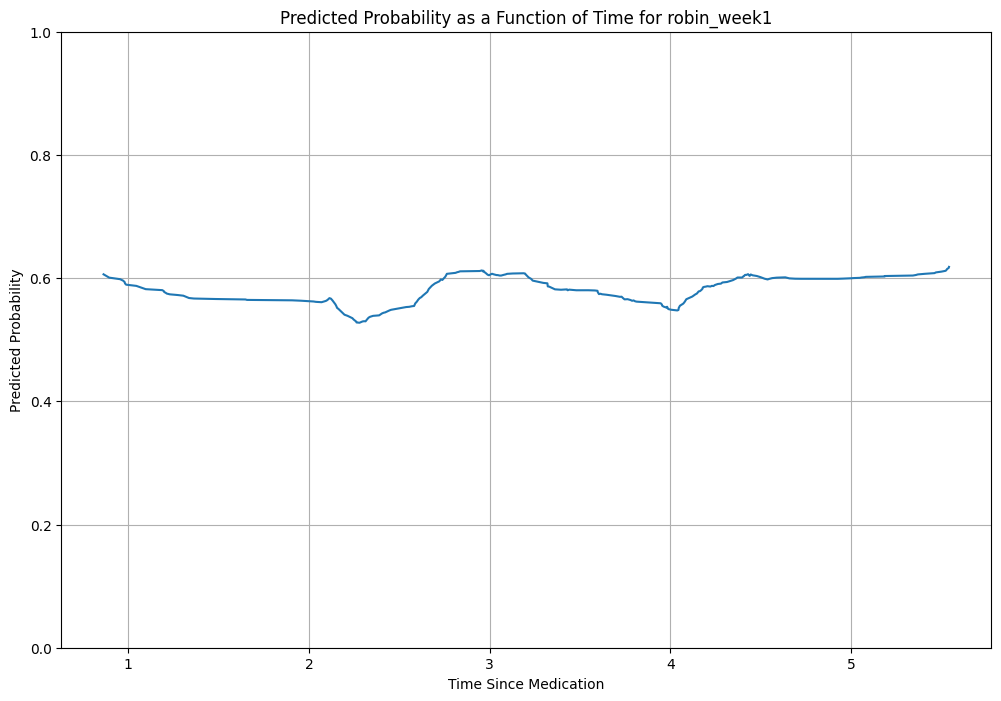

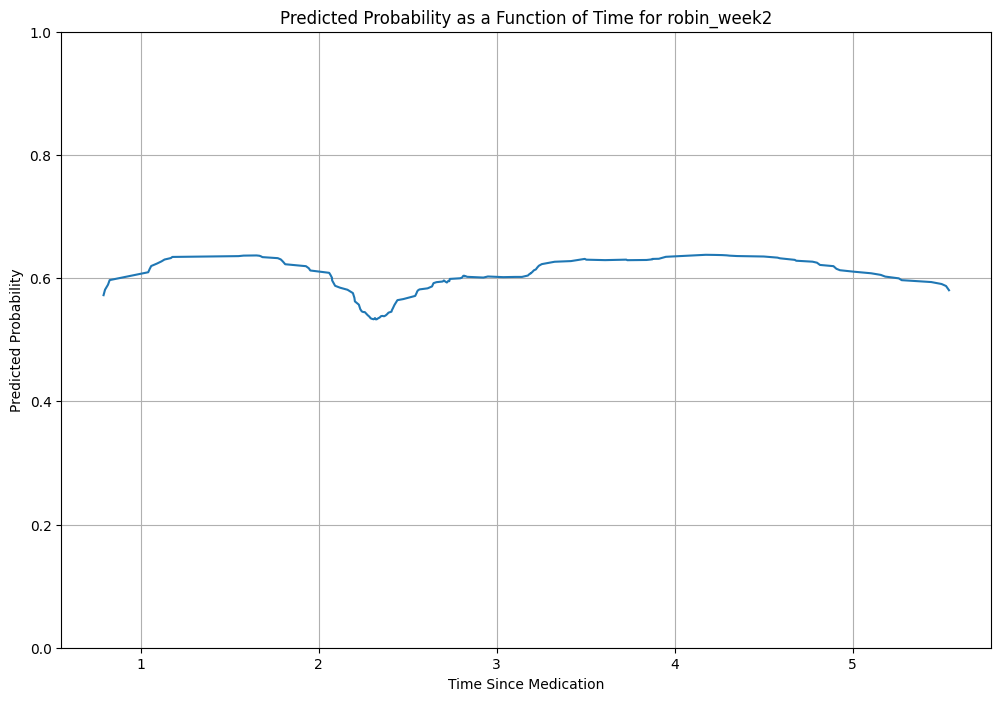

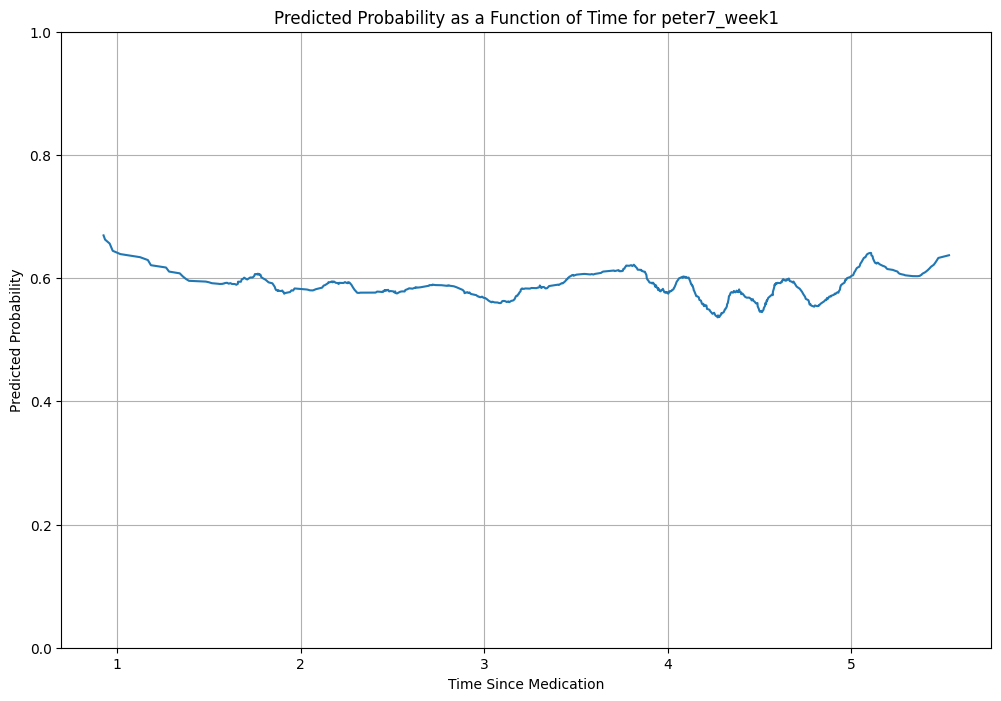

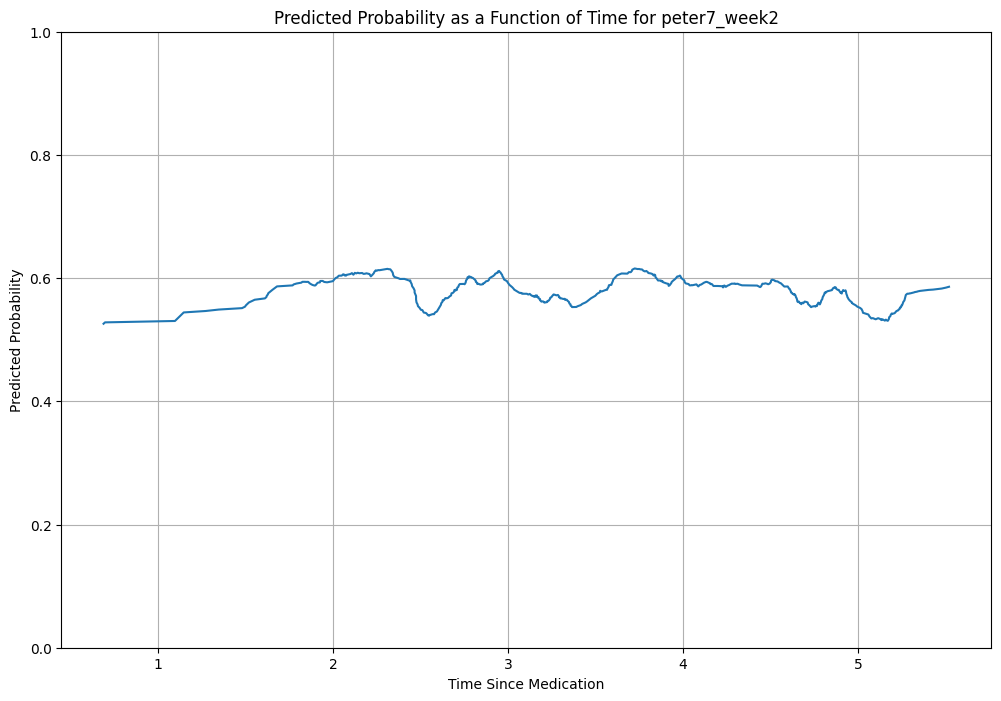

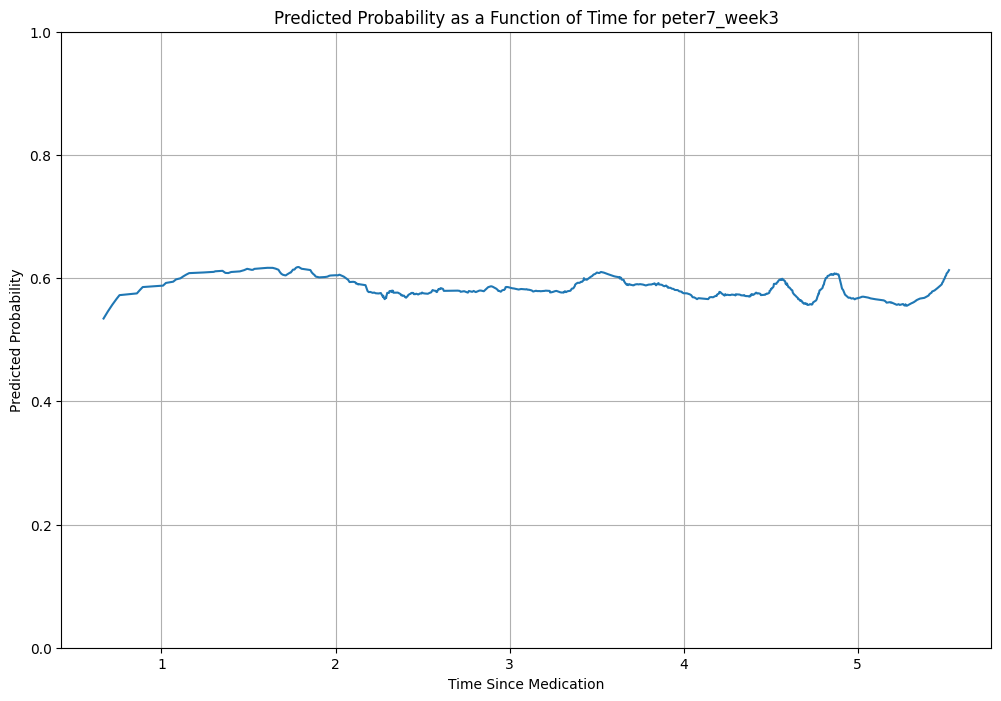

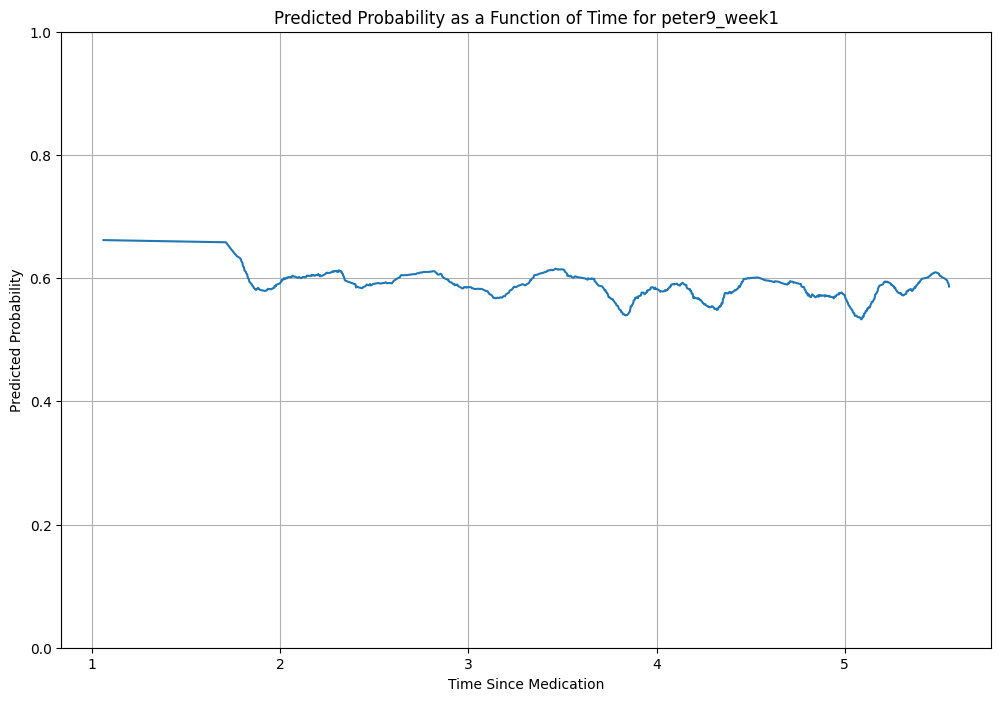

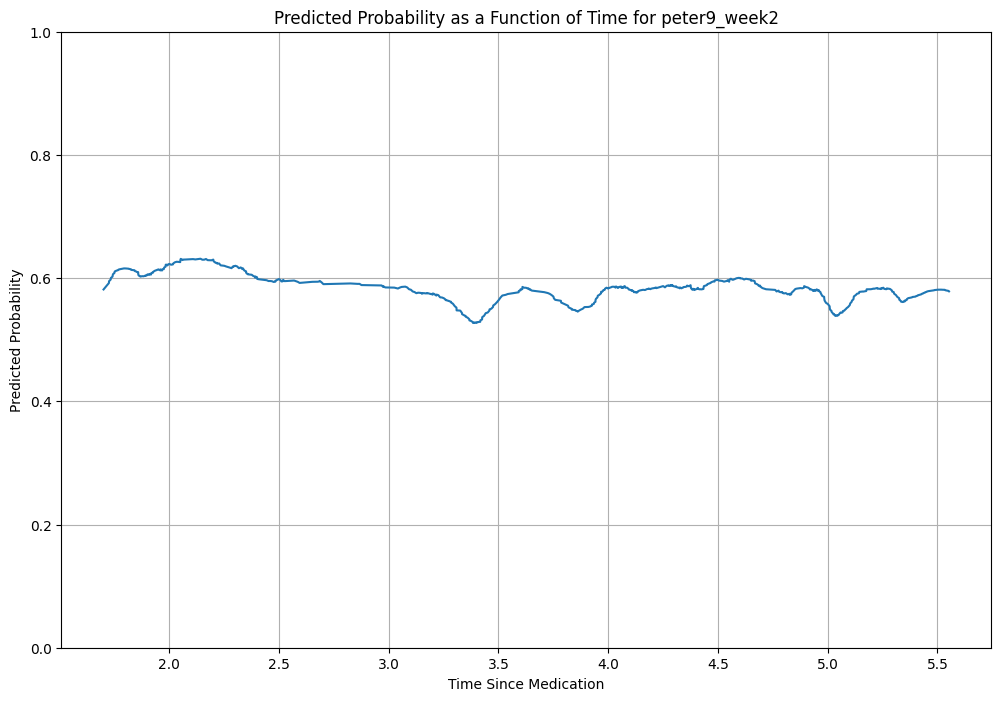

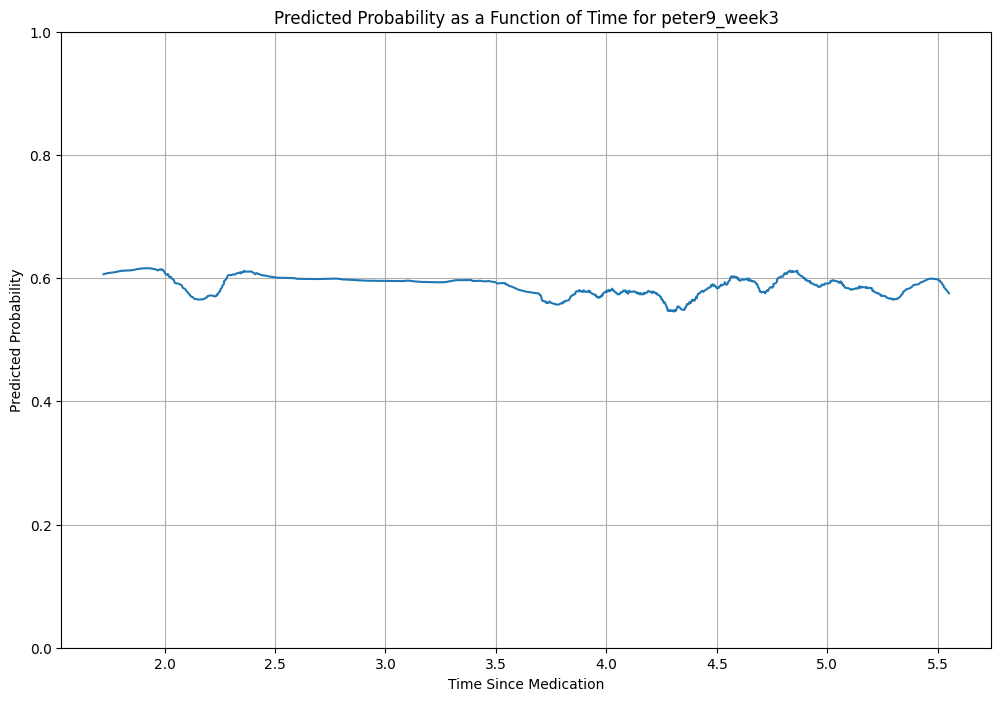

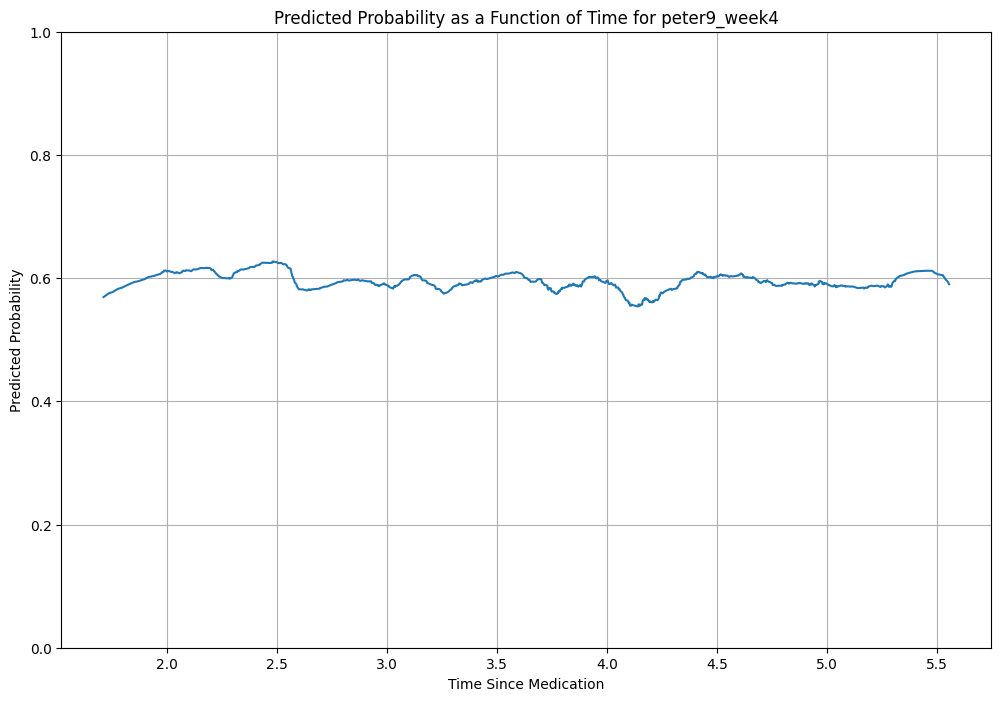

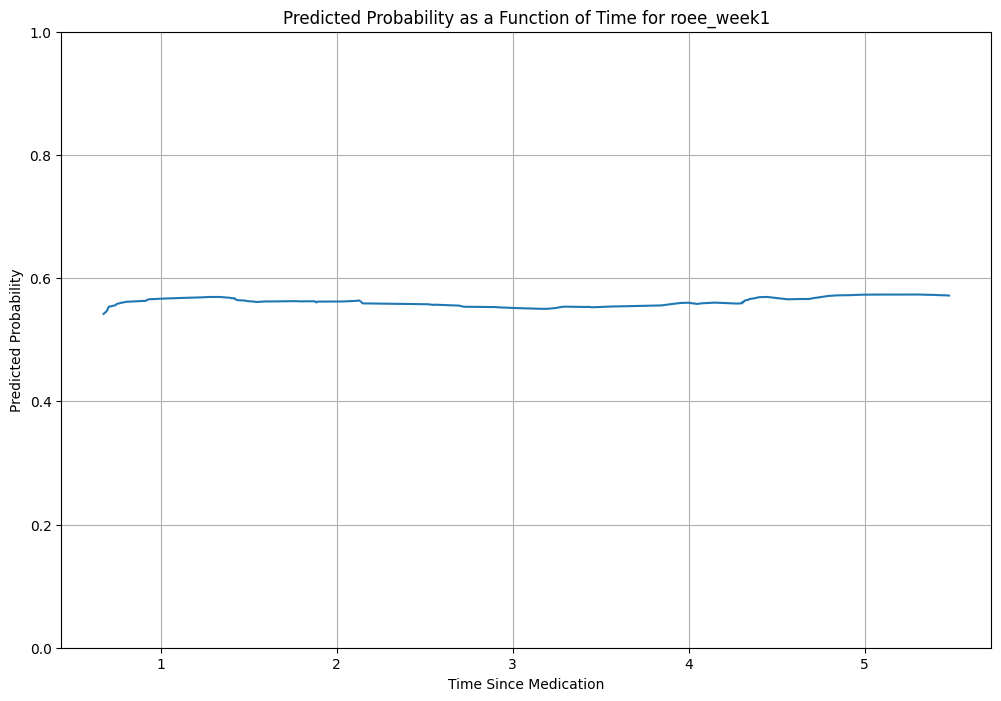

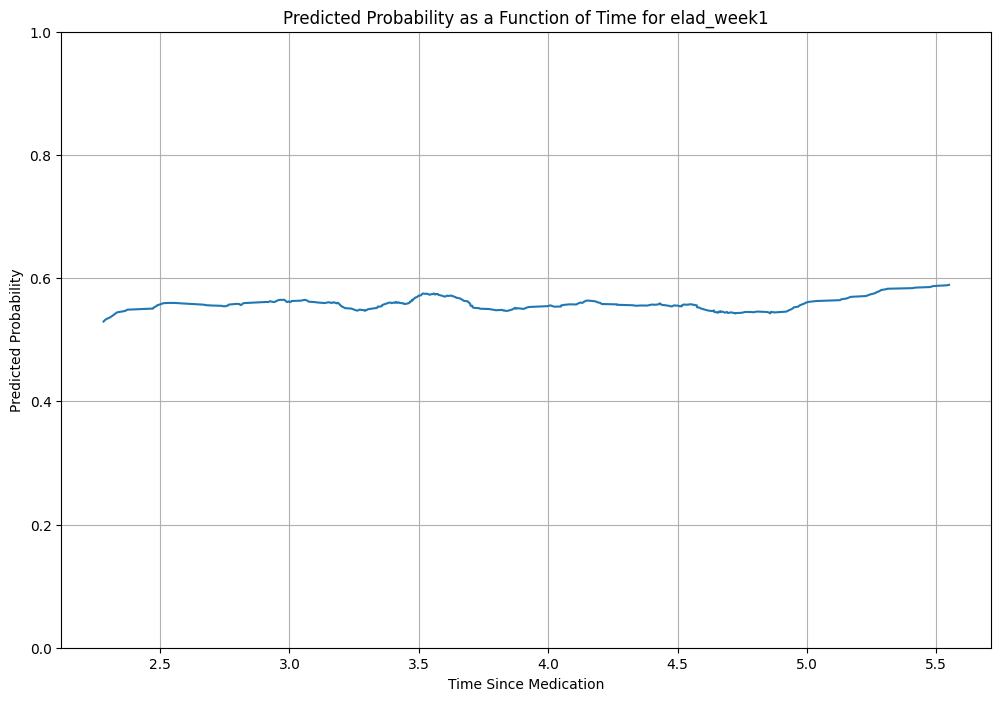

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

users = users_daily["user"].unique()

for user in users:
    df_filtered = users_daily[users_daily["user"] == user].sort_values(by='time_since_med')
    x = df_filtered['time_since_med']
    y = df_filtered['predicted_proba']
    plt.figure(figsize=(12, 8))
    y_savgol = savgol_filter(y, window_length=67, polyorder=3)
    plt.plot(x, y_savgol)
    plt.ylim(0, 1)
    plt.xlabel('Time Since Medication')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability as a Function of Time for {user}')
    plt.grid(True)
    plt.show()
